# Анализ товарного ассортимента интернет-магазина товаров для дома и быта «Пока все ещё тут»

## Материалы:

- [Интерактивный дашборд о количестве покупок в интернет-магазине](https://public.tableau.com/app/profile/anna5037/viz/shared/G3C8D4B27)
- [Презентация](https://view.genial.ly/6351330cabb3670018a4aec2/presentation-basic-presentation)

## Описание проекта

**Цель:** Разработать аналитические инструменты для принятия решений по товарному ассортименту интернет-магазина.

**Задачи:**
- Провести исследовательский анализ данных.
- Сегментировать торговый ассортимент.
- Сформулировать и проверить статистические гипотезы.
- Проанализировать ключевые бизнес-метрики по товарному ассортименту.
- Визуализировать и подготовить дашборд.

**Результат исследования:** Рекомендации по тому, как принимать решение по товарному ассортименту интернет-магазина.

## Описание данных

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки в  *ecommerce_dataset.csv* :

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

## Изучение и предобработка данных

In [ ]:
# Импорт библиотек

import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Лемматизация
from pymystem3 import Mystem
from collections import Counter

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# Статистика
from scipy import stats as st

# Дополнительные настройки
import re
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Загрузим и изучим данные

ecommerce = pd.read_csv('/datasets/ecommerce_dataset.csv')

ecommerce.info()
display(ecommerce.head())
display(ecommerce.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


,date,customer_id,order_id,product,quantity,price
6732,2019103111,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"Таз пластмассовый 40,0 л пищевой овальный (Иж)...",1,404.0
6733,2019103112,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0
6734,2019103113,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,Герань домашняя (пеларгония зональная) цветуща...,1,157.0
6735,2019103114,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6736,2019103116,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0


**Вывод по данным:**

- Данные представлены в виде таблицы, включающей в себя 6 737 строк и 6 столбцов.
- Количество строк в каждом столбце одинаково, что говорит о том, что в таблице, скорее всего, нет пропущенных данных.
- Столбец с датой заказов **date** необходимо привести в нужный формат даты и времени.
- Для удобства анализа следует привести названия в столбце с наименованием товаров **product** к нижнему регистру и заменить 'ё' на 'е', чтобы избежать разного написания одних и тех же слов.
- Проверить данные на дубликаты.

In [ ]:
# Изменим формат данных в столбце с датой заказов 'date'
ecommerce['date'] = pd.to_datetime(ecommerce['date'], format='%Y%m%d%H')

# Приведем названия товаров в столбце 'product' к нижнему регистру:
ecommerce['product'] = ecommerce['product'].str.lower()
ecommerce['product'] = ecommerce['product'].replace('ё', 'е', regex=True)

# Проверим на дубликаты и пропуски
print('Количество дубликатов: {}\n'.format(ecommerce.duplicated().sum()))
print('\nКоличество пропусков: ')
display(ecommerce.isna().sum())

# Проверим внесенные изменения и выведим произвольный семпл из таблицы
display(ecommerce.info())
display(ecommerce.sample(5))

Количество дубликатов: 0


Количество пропусков: 


date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6737 non-null   datetime64[ns]
 1   customer_id  6737 non-null   object        
 2   order_id     6737 non-null   int64         
 3   product      6737 non-null   object        
 4   quantity     6737 non-null   int64         
 5   price        6737 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 315.9+ KB


None

,date,customer_id,order_id,product,quantity,price
879,2018-11-20 14:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69062,"сушилка мульти 10м (1002010520027), attribute,...",1,937.0
64,2018-10-03 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68511,набор прищепок большие пластиковые rozenbal пи...,10,86.0
6505,2019-10-03 15:00:00,0309d37c-ab5f-4793-ba72-5484c019b840,72845,муляж яблоко зеленый 9 см полиуретан,40,59.0
5775,2019-07-10 09:00:00,42d3cb27-6519-4627-9b4a-5aa8ee600203,14897,декабрист в горшке d12 цвет фуксии,1,139.0
3813,2019-05-15 08:00:00,3976660e-6cca-4009-a170-be13f13ed459,14778,"рассада капусты кольраби мадонна, кассета по 10шт",1,195.0


- Узнаем период данных в датасете:

In [ ]:
print('В датасете представлены данные с', ecommerce['date'].min(), 'по', ecommerce['date'].max())

В датасете представлены данные с 2018-10-01 00:00:00 по 2019-10-31 16:00:00


In [ ]:
# Добавим в датасет новые столбцы, выделив из дат заказов месяц, неделю, день, час

ecommerce['month'] = ecommerce['date'].dt.strftime('%Y-%m')
ecommerce['week'] = ecommerce['date'].dt.strftime('%Y-%U')
ecommerce['day'] = ecommerce['date'].dt.dayofweek
ecommerce['order_date'] = ecommerce['date'].dt.date
ecommerce['hour'] = ecommerce['date'].dt.hour

### Изучим выбросы в данных

In [ ]:
print('Количество уникальных заказов в датасете:', len(ecommerce['order_id'].unique()))
print('Количество уникальных пользователей в датасете:', len(ecommerce['customer_id'].unique()))

customers = ecommerce.groupby('order_id').agg({'customer_id':'nunique'}).query('customer_id > 1')
display(customers.head())

Количество уникальных заказов в датасете: 2784
Количество уникальных пользователей в датасете: 2451


,customer_id
order_id,
14872,2
68785,2
69283,2
69310,2
69345,2


In [ ]:
print('Количество уникальных заказов с разными пользователями:', customers.shape[0])

Количество уникальных заказов с разными пользователями: 29


Возможно, при сборе данных был какой-то систменый сбой, поэтому в данных присутсвует 29 уникальных заказов, которые числятся за разными пользователями. 

Поищем еще неявные дубликаты в данных. 

In [ ]:
display(ecommerce.describe().T)

,count,mean,std,min,25%,50%,75%,max
order_id,6737.0,43128.948345,27899.414662,12624.0,14827.0,68503.0,70504.0,73164.0
quantity,6737.0,2.501559,15.266478,1.0,1.0,1.0,1.0,1000.0
price,6737.0,462.028499,871.296064,9.0,101.0,135.0,398.0,14917.0
day,6737.0,2.718421,2.001738,0.0,1.0,3.0,4.0,6.0
hour,6737.0,13.863589,4.969169,0.0,10.0,14.0,18.0,23.0


In [ ]:
# посчитаем 95-й и 99-й перцентили количества товаров в одном заказе, чтобы найти границу для определения аномалий

print(np.percentile(ecommerce['quantity'], [95, 99]))

[ 6.   26.64]


Только 5% заказов содержат количество товаров больше 6.

In [ ]:
# Вычислим верхнюю нормальную границу количества товаров в одном заказе

display(round(np.mean(ecommerce['quantity']) + np.std(ecommerce['quantity']) * 3))

48

In [ ]:
# Посчитаем сколько в данных заказов выше нормы

print('Количество заказов, в которых товаров выше нормы:', ecommerce[ecommerce['quantity'] > 48].shape[0])
display(ecommerce[ecommerce['quantity'] > 48].sort_values(by='quantity', ascending=False).head())

Количество заказов, в которых товаров выше нормы: 35


,date,customer_id,order_id,product,quantity,price,month,week,day,order_date,hour
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0,2019-06,2019-24,1,2019-06-18,15
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,2019-06,2019-23,1,2019-06-11,7
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,муляж яблоко 9 см красное,300,51.0,2019-05,2019-20,0,2019-05-20,21
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"ручка-скоба рс-100 белая *трибатрон*, 1108035",200,29.0,2018-12,2018-49,0,2018-12-10,14
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.0,2018-11,2018-43,3,2018-11-01,8


Количеством вантузов в 1000 штук не удивить, но его стоимость в **675 рублей** выглядит неправдоподобно, учитывая что средняя стоимость вантузов примерно 100 рублей. Возможно, это опечатка. Удалим эту строку из датасета, чтобы в дальнейшем анализе этот выброс не влиял на результаты исследования:

In [ ]:
ecommerce.drop(ecommerce[ecommerce['order_id'] == 71743].index, inplace=True)

In [ ]:
print('Среднее количество товаров без учета выбросов:', ecommerce.query('quantity <= 48')['quantity'].mean())

Среднее количество товаров без учета выбросов: 1.847806624888093


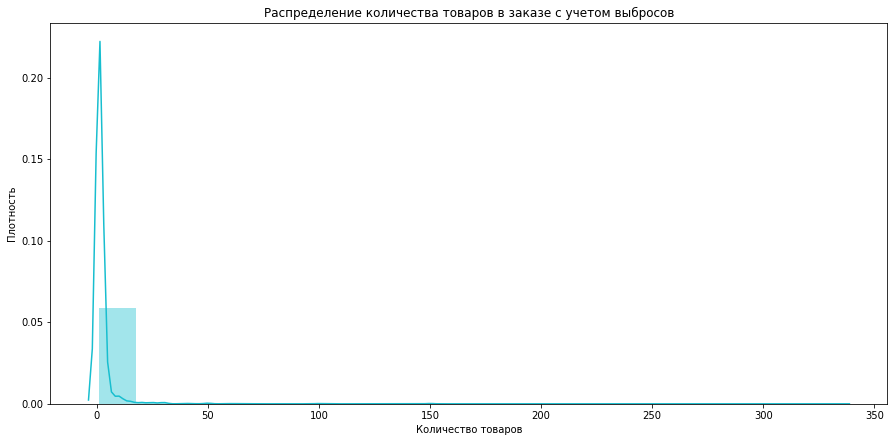

In [ ]:
# Посмотрим на графике распределение количества товаров в заказе с учетом выбросов

plt.figure(figsize=(15, 7))
sns.distplot(ecommerce['quantity'], bins=20, color='C9')
plt.title('Распределение количества товаров в заказе с учетом выбросов')
plt.xlabel('Количество товаров')
plt.ylabel('Плотность')
plt.show()

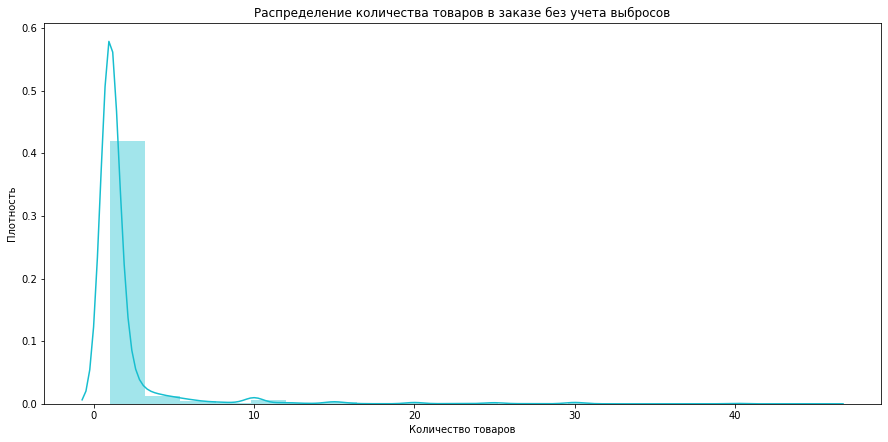

In [ ]:
# Посмотрим на графике распределение количества товаров в заказе без учета выбросов

plt.figure(figsize=(15, 7))
sns.distplot(ecommerce['quantity'][ecommerce['quantity'] <= 48], bins=20, color='C9')
plt.title('Распределение количества товаров в заказе без учета выбросов')
plt.xlabel('Количество товаров')
plt.ylabel('Плотность')
plt.show()

По графикам видно, что большинство покупателей заказывают по одному товару каждого наименования. Но встречаются и аномальные значения в виде покупателей, которые заказывают оптом. 

Если учитывать всех покупателей, то в среднем каждый покупатель заказывает 2.5 товара и не более 48 позиций одного наименования.

На текущем этапе для дальнейшего анализа отбрасывать аномальные значения из данных не будем.

In [ ]:
print(np.percentile(ecommerce['price'], [95, 99]))

[1949.   4226.75]


5% товаров имеет стоимость выше 2 000 рублей.

In [ ]:
# Вычислим верхнюю нормальную границу стоимости товара

display(round(np.mean(ecommerce['price']) + np.std(ecommerce['price']) * 3))

3076

In [ ]:
print('Количество строк, в которых стоимость товара выше нормы:', ecommerce[ecommerce['price'] > 3076].shape[0])
display(ecommerce[ecommerce['price'] > 3076].head())

Количество строк, в которых стоимость товара выше нормы: 156


,date,customer_id,order_id,product,quantity,price,month,week,day,order_date,hour
19,2018-10-01 21:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,2018-10,2018-39,0,2018-10-01,21
51,2018-10-02 15:00:00,494a90f5-2198-4212-8fc9-e3e22ad7afd9,68505,ерш для туалета с подставкой malibu фарфор 47х...,1,3524.0,2018-10,2018-39,1,2018-10-02,15
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,2018-10,2018-39,1,2018-10-02,18
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,2018-10,2018-39,1,2018-10-02,19
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,2018-10,2018-39,1,2018-10-02,20


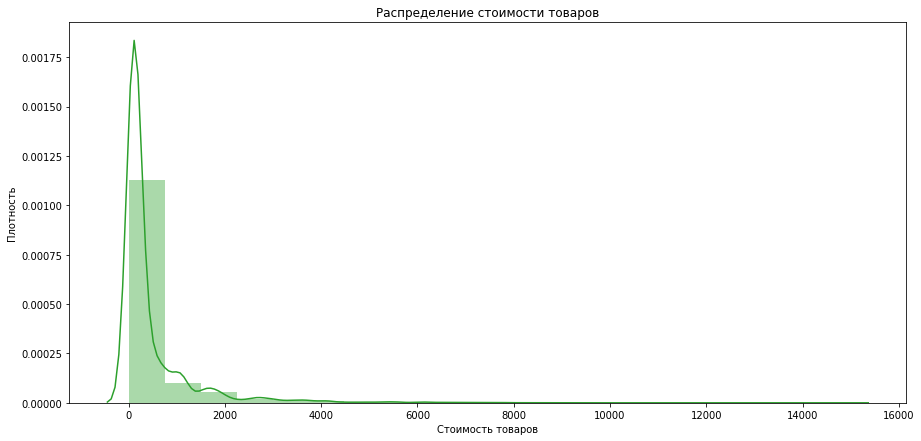

In [ ]:
# Посмотрим на распределение стоимости товаров

plt.figure(figsize=(15, 7))
sns.distplot(ecommerce['price'], bins=20, color='C2')
plt.title('Распределение стоимости товаров')
plt.xlabel('Стоимость товаров')
plt.ylabel('Плотность')
plt.show()

Стоимость товаров в корзине в среднем 462 рубля, при этом стоимость товара не превышает цену в 3076 рублей. Но и здесь есть 156 аномальных товаров, стоимость которых выше этой цены. Убирать из данных эти товары не стоит, так как в действительности эти товары находятся в указанной ценовой категории.

Также отметим, что мелкие товары вроде крючков мало стоят и заказываются в больших количествах в сравнение с крупными товарами вроде сумок и тележек.

In [ ]:
ecommerce = ecommerce.query('order_id not in @customers.index')

In [ ]:
orders = ecommerce.groupby('order_id').agg({'order_date':'nunique'}).query('order_date > 1').sort_values(by='order_date', ascending=False)

print('Количество уникальные заказов с разными датами:', orders.shape[0])
display(orders.head())

Количество уникальные заказов с разными датами: 165


,order_date
order_id,
70960,57
14833,22
69162,15
71148,11
13547,7


In [ ]:
display(ecommerce[ecommerce['order_id'] == 70960].head())

print('Количество строк в датасете для заказа с id70960: {}\n'.format(ecommerce[ecommerce['order_id'] == 70960].shape[0]))

,date,customer_id,order_id,product,quantity,price,month,week,day,order_date,hour
2589,2019-04-01 16:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,сумка-тележка 2-х колесная gimi argo красная,1,1087.0,2019-04,2019-13,0,2019-04-01,16
2600,2019-04-02 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,сумка-тележка 2-х колесная gimi argo красная,1,1087.0,2019-04,2019-13,1,2019-04-02,10
2622,2019-04-03 08:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,сумка-тележка 2-х колесная gimi argo красная,1,1087.0,2019-04,2019-13,2,2019-04-03,8
2718,2019-04-07 15:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,сумка-тележка 2-х колесная gimi argo красная,1,1087.0,2019-04,2019-14,6,2019-04-07,15
2734,2019-04-08 09:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,сумка-тележка 2-х колесная gimi argo красная,1,1087.0,2019-04,2019-14,0,2019-04-08,9


Количество строк в датасете для заказа с id70960: 60



165 уникальным заказам присвоены разные даты совершения покупки. Здесь также явно пошел какой-то сбой. Например, заказ с id70960, в котором куплена одна сумка-тележка повторяется 60 раз. Мы не можем знать в какое в итоге время совершен заказ, но мы точно знаем, что заказ был и был один. Поэтому в таких заказах оставим только строки с последней датой заказа, остальные дубликаты заказов удалим:

In [ ]:
ecommerce = ecommerce.drop_duplicates(subset=['order_id', 'product'], keep='last', inplace=False)

# Проверка
display(ecommerce[ecommerce['order_id'] == 70960])

,date,customer_id,order_id,product,quantity,price,month,week,day,order_date,hour
6706,2019-10-28 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,сумка-тележка 2-х колесная gimi argo красная,1,1087.0,2019-10,2019-43,0,2019-10-28,10


In [ ]:
print('Количество строк в датасете после очистки данных: {}\n'.format(ecommerce.shape[0]))

Количество строк в датасете после очистки данных: 4784



Данные приведены в порядок, можно приступать к их исследованию.

## Исследовательский анализ данных

- Посмотрим на динамику заказов во времени, чтобы определить как меняется интенсивность спроса в зависимости от сезона:

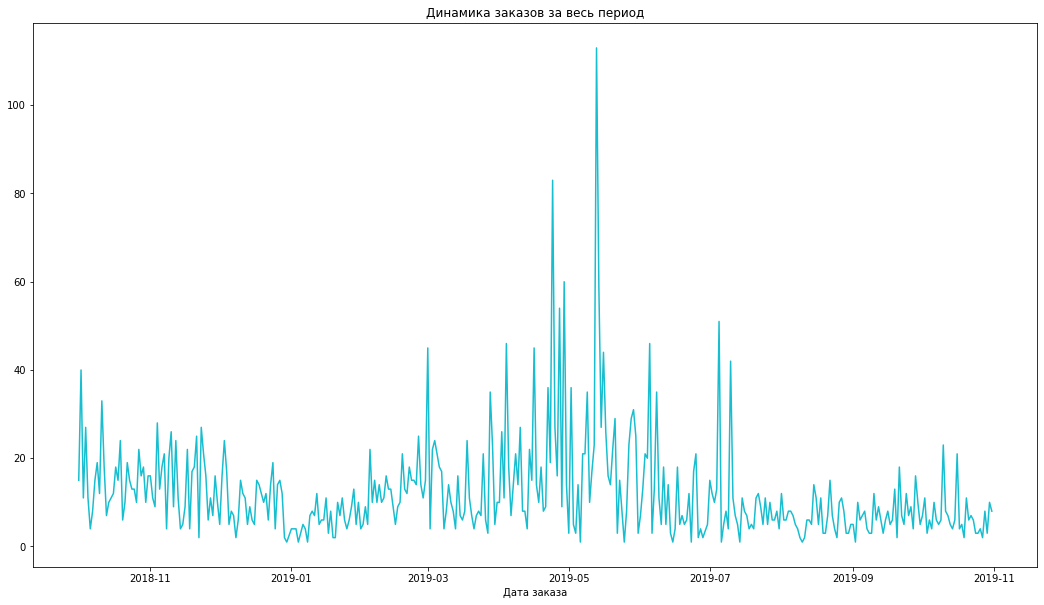

In [ ]:
ecommerce.groupby('order_date').agg({'order_id':'count'}).plot(figsize=(18, 10), color='C9', legend=False)
plt.title('Динамика заказов за весь период')
plt.xlabel('Дата заказа')
plt.show()

На графике видно, что пик продаж по количеству проданных наименований товаров приходится на май-июнь. Учитывая, что в каждом заказе может быть несколько наименований, посмотрим на динамику количества уникальных заказов:

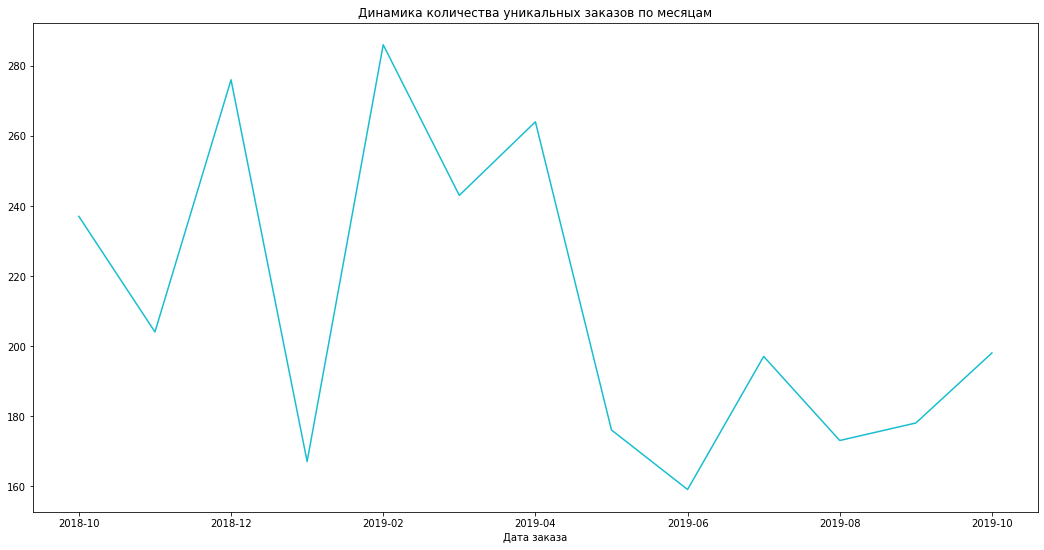

In [ ]:
ecommerce.groupby('month').agg({'order_id':'nunique'}).plot(figsize=(18, 9), color='C9', legend=False)
plt.title('Динамика количества уникальных заказов по месяцам')
plt.xlabel('Дата заказа')
plt.show()

Наибольшее количество заказов совершается в декабре, феврале и апреле. Декабрь один из самых прибыльных месяцев в году из-за приближения новогодних праздников. Увеличение заказов в апреле, возможно, происходит из-за подготовки к дачно-садовому периоду летом.

В январе и в летний период количество заказов сильно снижается. Январь - это практически всегда провальный месяц, так как после новогодних праздников нужно прийти в себя и дотянуть до первой зарплаты в году. А летом большинство уезжает в отпуска.


### Категоризация товаров

Для дальнейшего исследования нам нужно разбить все товары на категории. Столбец *product* с наименованиями товаров содержит абра-кадабру с множеством различных написаний одного и того же товара, что сильно затрудняет присваивание категорий. Поэтому воспользуемся лемматизацией.

In [ ]:
print('Количество уникальных продуктов:', len(ecommerce['product'].unique()))

Количество уникальных продуктов: 2328


In [ ]:
# Избавимся от цифр и английских букв в строках

ecommerce['product_rename'] =  ecommerce['product'].apply(lambda x: re.sub(r'[^А-Яа-яd -]', '', str(x)))

In [ ]:
ecommerce['product_rename'] = ecommerce['product_rename'].str.replace('   ', ' ', regex=True)
ecommerce['product_rename'] = ecommerce['product_rename'].str.replace('  ', ' ', regex=True)
ecommerce['product_rename'] = ecommerce['product_rename'].str.rstrip()

display(ecommerce['product_rename'].value_counts().head())

пеларгония розебудная укорененный черенок              132
пеларгония розебудная d d укорененный черенок           64
сумка-тележка -х колесная синяя                         56
пеларгония зональная диам см сиреневый полумахровый     52
сушилка для белья потолочная лиана м                    45
Name: product_rename, dtype: int64

In [ ]:
# Лемматизация

m = Mystem()
ecommerce['lemmas'] = ecommerce['product_rename'].apply(m.lemmatize)
lemmas = Counter(ecommerce['lemmas'].sum()).most_common()
display(lemmas)

[(' ', 24810),
 ('\n', 4494),
 ('см', 2169),
 ('d', 1275),
 ('для', 1004),
 ('пеларгония', 820),
 ('х', 696),
 ('рассада', 594),
 ('- ', 584),
 ('в', 545),
 ('л', 502),
 ('зональный', 487),
 ('-', 480),
 ('шт', 461),
 ('диам', 452),
 ('с', 412),
 ('кассета', 396),
 ('сорт', 360),
 ('тележка', 344),
 ('махровый', 340),
 (' - ', 339),
 ('черенок', 332),
 ('укоренять', 330),
 ('сумка', 312),
 ('белье', 305),
 ('красный', 301),
 ('белый', 300),
 ('объем', 296),
 ('горшок', 275),
 ('сушилка', 273),
 ('по', 257),
 ('цветок', 243),
 ('розебудный', 243),
 ('доска', 234),
 ('кухня', 225),
 ('зелень', 220),
 ('синий', 200),
 ('розовый', 194),
 ('гладильный', 192),
 ('полумахровый', 185),
 ('однолетний', 184),
 ('м', 173),
 (' -', 172),
 ('петуния', 171),
 ('томат', 170),
 ('россия', 167),
 ('муляж', 166),
 ('кг', 162),
 ('помидор', 162),
 (' -\n', 153),
 ('ника', 153),
 ('и', 151),
 ('хозяйственный', 136),
 ('сиреневый', 130),
 ('среднеспелый', 121),
 ('черный', 119),
 ('герань', 116),
 ('домашн

На основе полученного списка уникальных лемм разобъем все товары на 10 категорий:

- Аксессуары для ухода за одеждой и обувью
- Посуда
- Текстиль
- Бытовая техника
- Хранение и порядок
- Чистота и уборка
- Декор и подарки
- Овощи, фрукты, зелень
- Комнатные растения и садовые цветы
- Для ремонта и стройки

In [ ]:
# Функция, которая по ключевым словам в наименовании товара присваивает ему категорию

def lemmas_category(lemmas):
    if ('гладильный' in lemmas) or ('сушилка' in lemmas) or\
    ('одежда' in lemmas) or ('вешалка' in lemmas) or\
    ('подкладка' in lemmas) or ('подрукавник' in lemmas) or\
    ('обувь' in lemmas) or ('плечики' in lemmas) or\
    ('одежный' in lemmas) or ('обувной' in lemmas):
        return 'Аксессуары для ухода за одеждой и обувью'
    
    if ('пружина' in lemmas) or ('петля' in lemmas) or\
    ('проволочный' in lemmas) or ('инструмент' in lemmas) or\
    ('стремянка' in lemmas) or ('корыто' in lemmas) or\
    ('цинк' in lemmas) or ('строительный' in lemmas) or\
    ('сверло' in lemmas) or ('сварка' in lemmas) or ('стяжка' in lemmas) or\
    ('набор' in lemmas) or ('измерительный' in lemmas) or\
    ('длина' in lemmas) or ('батарейка' in lemmas) or\
    ('бензин' in lemmas) or ('шило' in lemmas) or\
    ('сметка' in lemmas) or ('уличный' in lemmas) or ('веревка' in lemmas):
        return 'Ремонт и стройка'
    
    if ('кружка' in lemmas) or ('лоток' in lemmas) or\
    ('сковорода' in lemmas) or ('сотейник' in lemmas) or ('салатник' in lemmas) or\
    ('кастрюля' in lemmas) or ('котел' in lemmas) or\
    ('овощеварка' in lemmas) or ('мантоварка' in lemmas) or\
    ('соковарка' in lemmas) or ('миска' in lemmas) or\
    ('противень' in lemmas) or ('нож' in lemmas) or\
    ('столовая' in lemmas) or ('столовый' in lemmas) or\
    ('чайный' in lemmas) or ('терка' in lemmas) or\
    ('толкушка' in lemmas) or ('тарелка' in lemmas) or\
    ('термокружок' in lemmas) or ('свч' in lemmas) or\
    ('ложка' in lemmas) or ('банка' in lemmas) or\
    ('крышка' in lemmas) or ('пищевой' in lemmas) or\
    ('овощ' in lemmas) or ('венчик' in lemmas) or\
    ('хлебница' in lemmas) or ('рыбочистка' in lemmas) or\
    ('бокал' in lemmas) or ('фужер' in lemmas) or\
    ('чайный' in lemmas) or ('форма' in lemmas) or\
    ('картофелемялка' in lemmas) or ('ножеточка' in lemmas) or\
    ('бутылка' in lemmas) or ('стакан' in lemmas) or\
    ('лезвие' in lemmas) or ('лопатка' in lemmas) or\
    ('ковш' in lemmas) or ('разделочный' in lemmas) or\
    ('термос' in lemmas) or ('сито' in lemmas) or\
    ('плита' in lemmas) or ('пресс' in lemmas):
        return 'Посуда'
    if ('чайник' in lemmas) and ('эмалированный' in lemmas) or ('заварочный' in lemmas):
        return 'Посуда'
    
    if ('покрывало' in lemmas) or ('хлопок' in lemmas) or\
    ('салфетка' in lemmas) or ('одеяло' in lemmas) or\
    ('полотенце' in lemmas) or ('подушка' in lemmas) or\
    ('скатерть' in lemmas) or ('плед' in lemmas) or ('халат' in lemmas):
        return 'Текстиль'
    
    if ('электрический' in lemmas) or ('миксер' in lemmas) or\
    ('фен' in lemmas) or ('паровой' in lemmas) or\
    ('пылесос' in lemmas) or ('весы' in lemmas) or\
    ('светильник' in lemmas):
        return 'Бытовая техника'
    
    if ('сумка' in lemmas) or ('тележка' in lemmas) or\
    ('кофр' in lemmas) or ('хранение' in lemmas) or\
    ('ящик' in lemmas) or ('коробка' in lemmas) or\
    ('корзина' in lemmas) or ('контейнер' in lemmas) or\
    ('таз' in lemmas) or ('полка' in lemmas) or ('комод' in lemmas):
        return 'Хранение и порядок'
    
    if ('цветок' in lemmas) and ('искусственный' in lemmas) or\
    ('композиция' in lemmas) or ('подарочный' in lemmas) or\
    ('открытка' in lemmas) or ('упаковка' in lemmas) or\
    ('новогодний' in lemmas) or ('картина' in lemmas) or\
    ('фотография' in lemmas) or ('муляж' in lemmas):
        return 'Декор и подарки'
    
    if ('рассада' in lemmas) and ('зелень' in lemmas) or ('томат' in lemmas) or\
    ('капуста' in lemmas) or ('перец' in lemmas) or ('огурец' in lemmas) or\
    ('тыква' in lemmas) or ('кабачок' in lemmas) or\
    ('клубника' in lemmas) or ('арбуз' in lemmas) or\
    ('дыня' in lemmas) or ('патиссон' in lemmas) or\
    ('баклажан' in lemmas) or ('земляника' in lemmas) or\
    ('морковь' in lemmas) or ('петрушка' in lemmas) or\
    ('пряный' in lemmas) or ('лекарственный' in lemmas):
        return 'Овощи, фрукты, зелень'
    
    if ('d' in lemmas) and ('вантуз' in lemmas) or\
    ('d' in lemmas) and ('щетка' in lemmas) or\
    ('d' in lemmas) and ('чехол' in lemmas) or\
    ('d' in lemmas) and ('коврик' in lemmas) or\
    ('d' in lemmas) and ('средство' in lemmas):
        return 'Чистота и уборка'
    
    if ('цветок' in lemmas) and ('рассада' in lemmas) or\
    ('однолетний' in lemmas) or ('многолетний' in lemmas) or\
    ('петуния' in lemmas) or ('черенок' in lemmas) or ('крупноцветковый' in lemmas) or\
    ('цвести' in lemmas) or ('садовый' in lemmas) or ('объем' in lemmas) or\
    ('растение' in lemmas) and ('комнатный' in lemmas) or\
    ('домашний' in lemmas) or ('горшок' in lemmas) or\
    ('кашпо' in lemmas) or ('пеларгония' in lemmas) or ('d' in lemmas): 
        return 'Комнатные растения и садовые цветы'
    if 'кассета' in lemmas:
        return 'Овощи, фрукты, зелень'
    
    if ('ванный' in lemmas) or ('ванна' in lemmas) or ('ванная' in lemmas) or\
    ('туалет' in lemmas) or ('туалетный' in lemmas) or\
    ('унитазный' in lemmas) or ('унитаз' in lemmas) or\
    ('белье' in lemmas) or ('стиральный' in lemmas) or\
    ('коврик' in lemmas) or ('ковер' in lemmas) or ('вантуз' in lemmas) or\
    ('посуда' in lemmas) or ('мытье' in lemmas) or ('чистка' in lemmas) or\
    ('щетка' in lemmas) or ('мыло' in lemmas) or ('швабра' in lemmas) or\
    ('зубной' in lemmas) or ('кухонный' in lemmas) or\
    ('круглый' in lemmas) or ('чистить' in lemmas) or\
    ('перчатка' in lemmas) or ('деревянный' in lemmas) or\
    ('тряпка' in lemmas) or ('скребок' in lemmas) or\
    ('ведро' in lemmas) or ('карниз' in lemmas) or\
    ('совок' in lemmas) or ('губка' in lemmas) or\
    ('антижир' in lemmas) or ('кольцо') or\
    ('мл' in lemmas) or ('чехол' in lemmas) or\
    ('придверный' in lemmas) or ('средство' in lemmas):
        return 'Чистота и уборка'
    
ecommerce['product_category'] = ecommerce['lemmas'].apply(lemmas_category)
print(ecommerce['product_category'].value_counts())

Комнатные растения и садовые цветы          1716
Овощи, фрукты, зелень                        688
Аксессуары для ухода за одеждой и обувью     585
Чистота и уборка                             468
Хранение и порядок                           437
Посуда                                       323
Декор и подарки                              297
Ремонт и стройка                             153
Текстиль                                      92
Бытовая техника                               25
Name: product_category, dtype: int64


In [ ]:
# Проверка

display(ecommerce.sample(3))

,date,customer_id,order_id,product,quantity,price,month,week,day,order_date,hour,product_rename,lemmas,product_category
1235,2018-12-17 13:00:00,0673033d-8bb9-4d9f-afc9-21f0276a5940,69407,пеларгония грандифлора махровая микс d-12 см,1,209.0,2018-12,2018-50,0,2018-12-17,13,пеларгония грандифлора махровая микс d- см,"[пеларгония, , грандифлора, , махровый, , м...",Комнатные растения и садовые цветы
3641,2019-05-13 11:00:00,eed1c77c-734e-4f27-b56b-a524af1af09d,14756,рассада зелени для кухни тимьян-чабрец розовый...,1,89.0,2019-05,2019-19,0,2019-05-13,11,рассада зелени для кухни тимьян-чабрец розовый...,"[рассада, , зелень, , для, , кухня, , тимь...","Овощи, фрукты, зелень"
446,2018-10-27 13:00:00,361981dd-a525-4245-bbf7-b22287f65ed9,68768,"коврик придверный, полукруглый из резины и кок...",1,899.0,2018-10,2018-42,5,2018-10-27,13,коврик придверный полукруглый из резины и коко...,"[коврик, , придверный, , полукруглый, , из,...",Чистота и уборка


In [ ]:
# Удалим столбцы, которые больше не понадобятся 'product_rename' и 'lemmas'

ecommerce = ecommerce.drop('product_rename', axis=1)
ecommerce = ecommerce.drop('lemmas', axis=1)

display(ecommerce.sample(5))

,date,customer_id,order_id,product,quantity,price,month,week,day,order_date,hour,product_category
1825,2019-02-14 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,70254,сумка-тележка 2-х колесная gimi argo фиолетовая,1,1087.0,2019-02,2019-06,3,2019-02-14,8,Хранение и порядок
1213,2018-12-15 15:00:00,b671b176-6d01-43f4-a168-a22ef061b2fd,69375,"ерш унитазный с деревянной ручкой , ваир 1712012",1,59.0,2018-12,2018-49,5,2018-12-15,15,Чистота и уборка
5977,2019-07-28 13:00:00,a7985efd-df3d-4040-a832-10291bc631f0,72123,сумка-тележка 3-х колесная gimi tris черная,1,1800.0,2019-07,2019-30,6,2019-07-28,13,Хранение и порядок
2506,2019-03-28 12:00:00,a6142764-478d-4357-bcbb-7f9bd35a98e5,14596,рассада зелени для кухни пастернак в кассете 6 шт,1,116.0,2019-03,2019-12,3,2019-03-28,12,"Овощи, фрукты, зелень"
2474,2019-03-26 10:00:00,5f1ca921-ded2-4866-8410-1167d8459a93,70856,герань домашняя (пеларгония зональная) цветуща...,1,157.0,2019-03,2019-12,1,2019-03-26,10,Комнатные растения и садовые цветы


### Анализ количественных характеристик категорий товаров

In [ ]:
# Добавим столбец с выручкой по каждой транзакции

ecommerce['revenue'] = ecommerce['price'] * ecommerce['quantity']

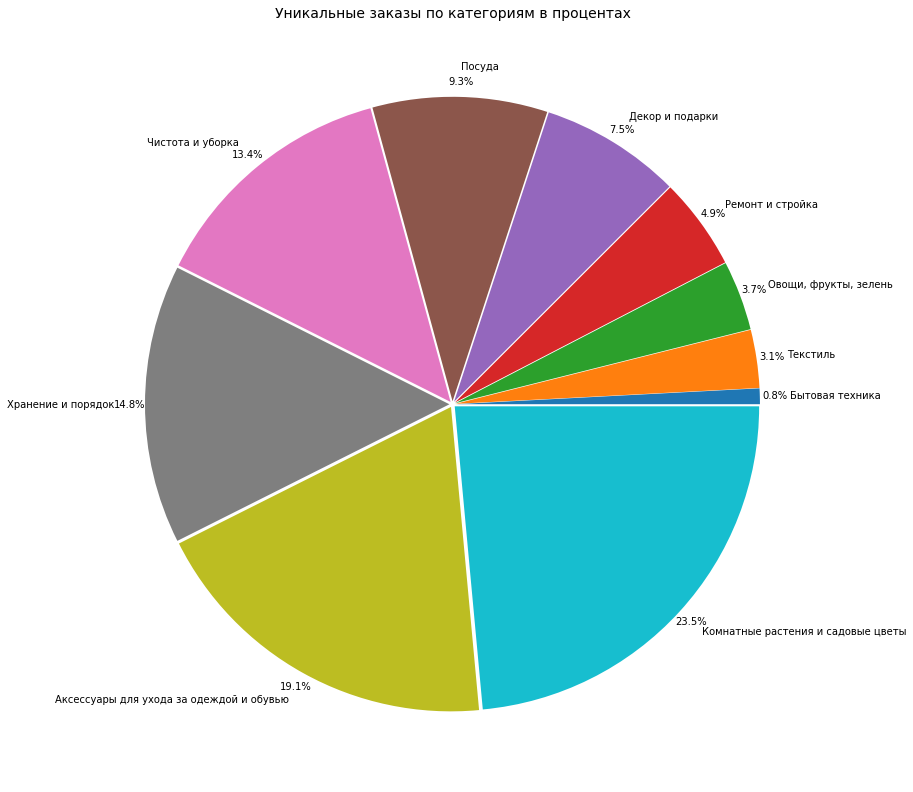

In [ ]:
# Посчитаем количество уникальных заказов в каждой категории товаров

categories = ecommerce.groupby('product_category')[['order_id']].nunique().sort_values(by='order_id')
plt.figure(figsize = (14, 14))
plt.pie(categories['order_id'], labels=categories.index, autopct='%.1f%%', explode=[0.01]*10, pctdistance=1.05)
plt.title('Уникальные заказы по категориям в процентах', fontsize=14)
plt.show()

Покупатели чаще всего заказывают товары в категориях:
- Комнатные растения и садовые цветы;
- Аксессуары для ухода за одеждой и обувью;
- Хранение и порядок.

Наименее популярные категории:
- Бытовая техника;
- Текстиль;
- Овощи, фрукты, зелень.


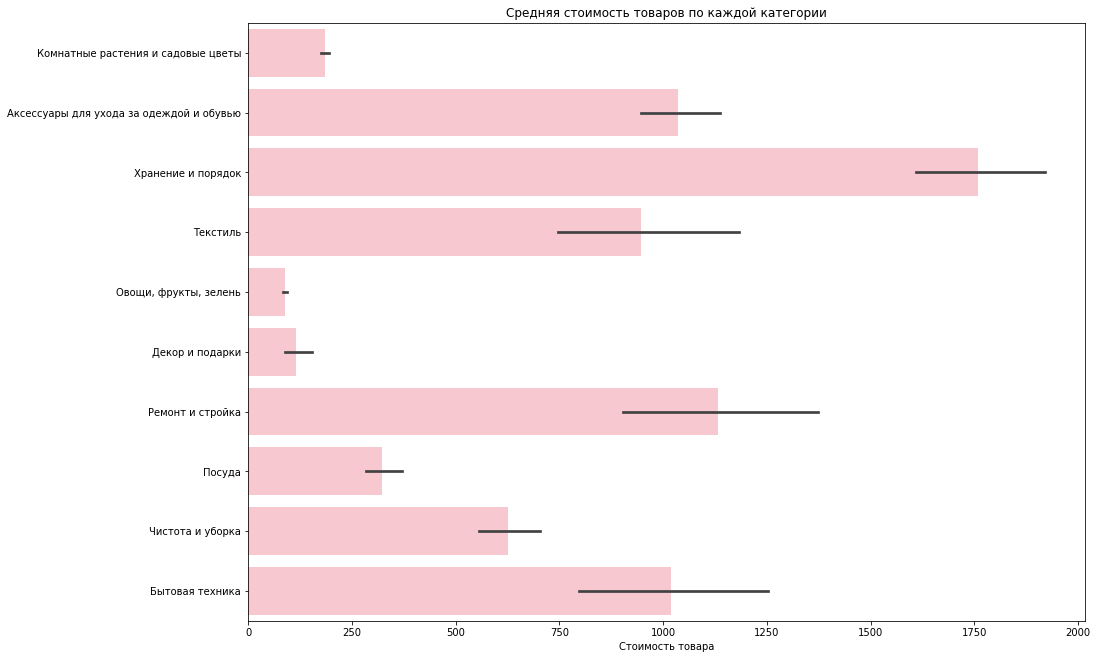

In [ ]:
# Посмотрим на средний ценник по каждой категории

plt.figure(figsize=(15, 11))
sns.barplot(data=ecommerce, y='product_category', x='price', color='pink')
plt.xlabel('Стоимость товара')
plt.ylabel('')
plt.title('Средняя стоимость товаров по каждой категории')
plt.show()

Наибольшие средние ценники свыше 1000 рублей в категориях:
- Хранение и порядок;
- Ремонт и стройка;
- Аксессуары для ухода за одеждой и обувью;
- Бытовая техника.

Наименьшие средние ценники до 200 рублей в категориях:
- Овощи, фрукты, зелень;
- Декор и подарки;
- Комнатные растения и садовые цветы.


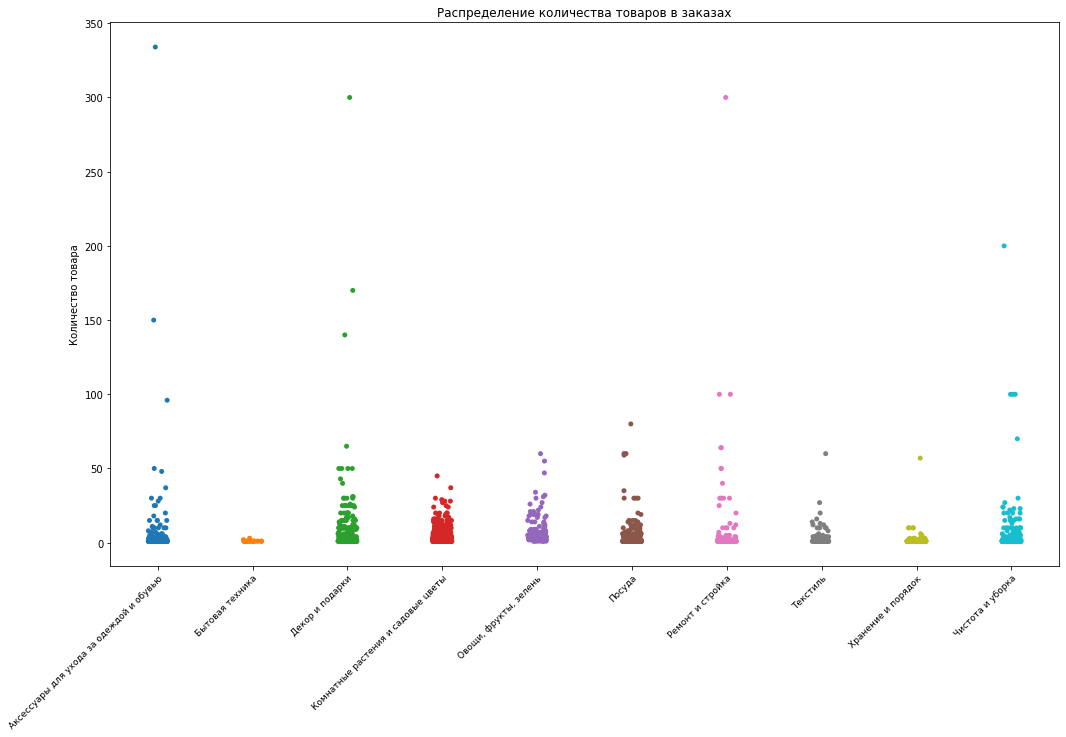

In [ ]:
# Посмотрим распределение количества товаров в заказах

quantity_in_orders = ecommerce.groupby(['product_category', 'order_id']).agg(
    {'quantity':'sum'}).reset_index()

plt.figure(figsize=(17, 10))
sns.stripplot(data=quantity_in_orders, x='product_category', y='quantity')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right', fontsize=9)
plt.title('Распределение количества товаров в заказах')
plt.xlabel('')
plt.ylabel('Количество товара')
plt.show()


На графике видно, в каких категориях есть выбросы по количеству товаров в заказе. Самый большой выброс по количеству в категории **Чистота и порядок**.
Также крупные выбросы присутствуют в категориях:
- Аксессуары для ухода за одеждой и обувью;
- Декор и подарки;
- Ремонт и стройка.


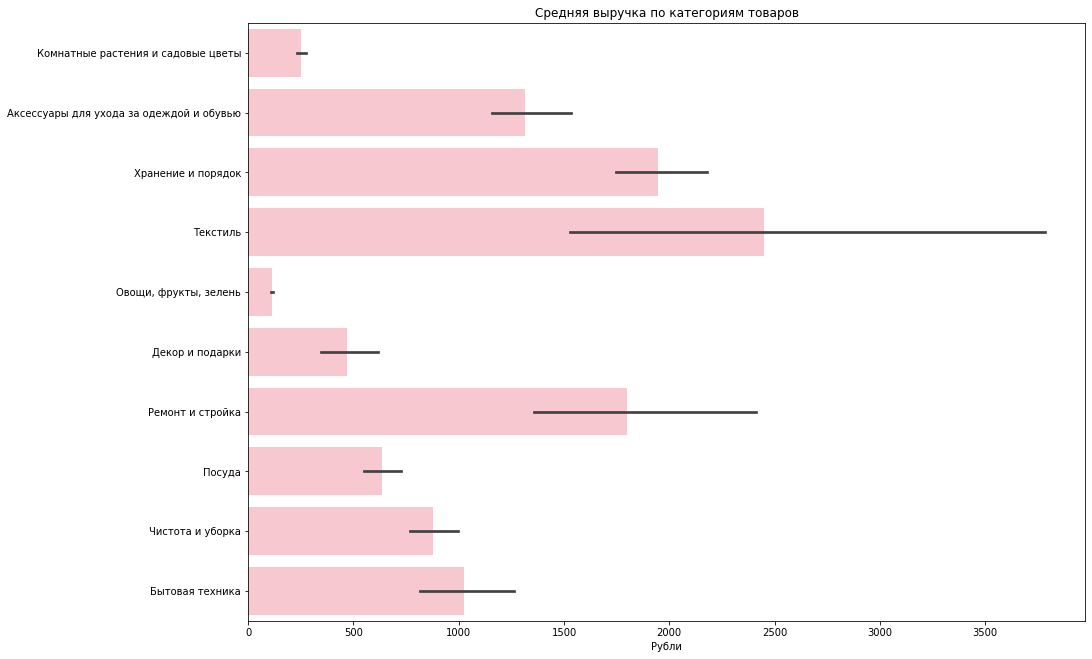

In [ ]:
# Посмотрим на среднюю выручку по категориям товаров

revenue_category = ecommerce.groupby('product_category').agg({'revenue':'mean'}).reset_index()
plt.figure(figsize=(15, 11))
sns.barplot(data=ecommerce, y='product_category', x='revenue', color='pink')
plt.xlabel('Рубли')
plt.ylabel('')
plt.title('Средняя выручка по категориям товаров')
plt.show()

Наибольшая средняя выручка свыше 2000 рублей в категориях:
- Текстиль;
- Чистота и уборка;
- Хранение и порядок.

Наименьшая средняя выручка ниже 500 рублей в категориях:
- Овощи, фрукты, зелень;
- Комнатные растения и садовые цветы;
- Декор и подарки.

**Вывод по исследовательскому анализу данных:**

Весь товарный ассортимент магазина мы разделили на 10 категорий:
- Аксессуары для ухода за одеждой и обувью
- Посуда
- Текстиль
- Бытовая техника
- Хранение и порядок
- Чистота и уборка
- Декор и подарки
- Овощи, фрукты, зелень
- Комнатные растения и садовые цветы
- Для ремонта и стройки

1. Наибольшее количество заказов совершается в декабре, феврале и апреле. Декабрь один из самых прибыльных месяцев в году из-за приближения новогодних праздников. Увеличение заказов в апреле, возможно, происходит из-за подготовки к дачно-садовому периоду летом.

2. В январе и в летний период количество заказов сильно снижается. Январь - это практически всегда провальный месяц, так как после новогодних праздников нужно прийти в себя и дотянуть до первой зарплаты в году. А летом большинство уезжает в отпуска.

3. Встречаются товары, которые закупают оптом: в основном это касается мелких дешевых предметов вроде крючков. 

4. **58 %** заказов покупателей приходятся на товары из категорий **Комнатные растения и садовые цветы**, **Аксессуары для ухода за одеждой и обувью**, **Хранение и порядок**.

5. **Средний ценник товара** свыше 1000 рублей приходится на товары из категорий **Хранение и порядок**, **Аксессуры для ухода за одеждой и обувью**, **Ремонт и стройка**, **Бытовая техника**.

6. **Средняя стоимость корзины** покупателя **462 рубля**, большинство заказов не превышают цену в **3076 рублей**. При этом в данных наблюдается **156 товаров**, которые сильно выходят за рамки средних показателей.

После исследовательского анализа, мы можем выдвинуть ряд гипотез:
1. Товары с небольшой ценой чаще заказывают в больших количествах, а крупные покупки совершаются реже.
2. В весенне-летний период заказы более крупные, чем в осенне-зимний период.
3. Ряд товаров обладает сезонность. Например, пик продаж у рассады приходится на конец весны - начало лета, так как начинается садово-огородный сезон.
4. Средний ценник заказов отличается в разные сезоны.
5. Средняя выручка по категориям товаров различается.

## Кластеризация товарного ассортимента

In [ ]:
# Удалим аномальные значения, чтобы качественно разделить данные на кластеры
ecommerce.drop(ecommerce[ecommerce['quantity'] == 1000].index, inplace=True)

ecommerce_q = ecommerce[['price', 'quantity', 'revenue']]

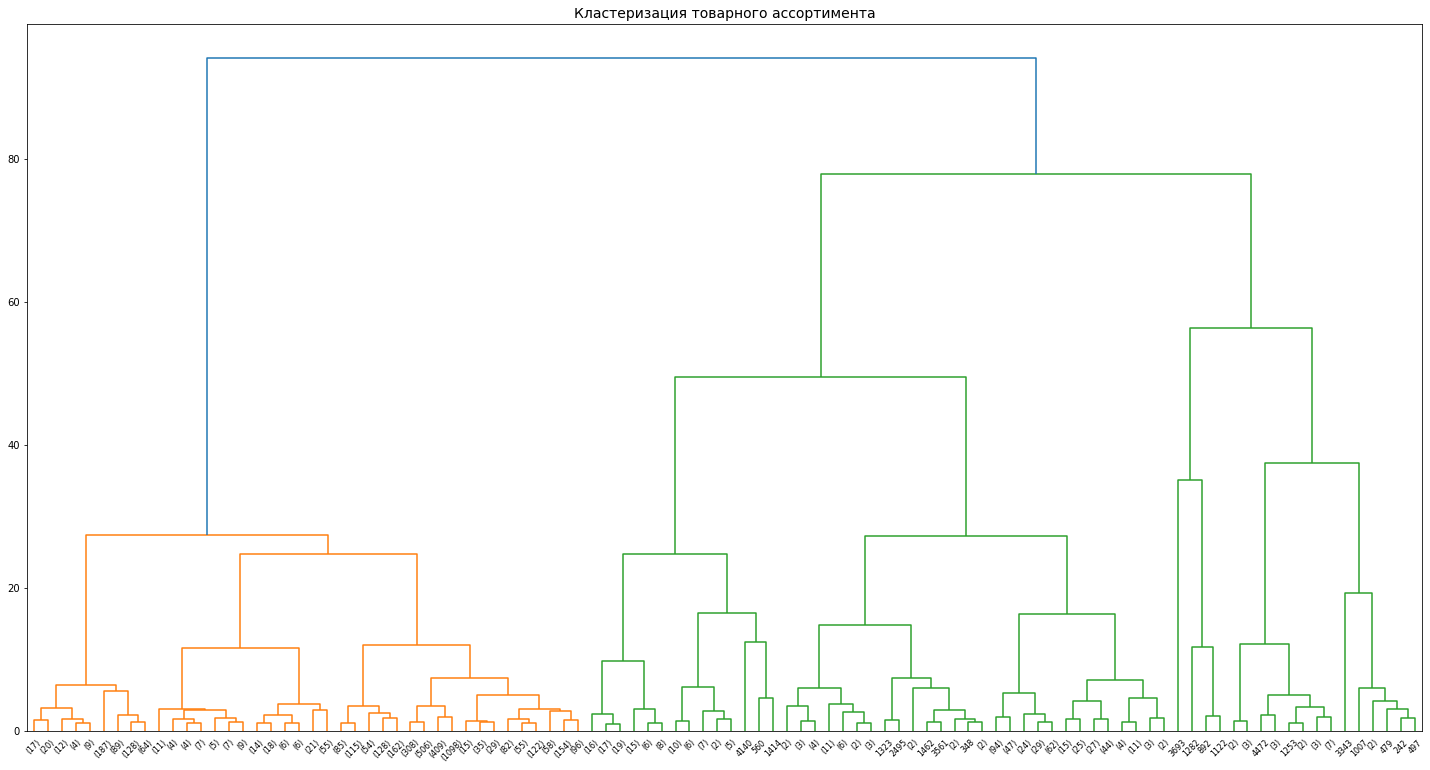

In [ ]:
# Зададим "стандартизатор"
scaler = StandardScaler()

# Стандартизируем данные
x_st = scaler.fit_transform(ecommerce_q)

# Сохраним матрицу расстояний
linked = linkage(x_st, method='ward')

# Построим дендрограмму
plt.figure(figsize=(25, 13))
plt.title('Кластеризация товарного ассортимента', fontsize=14)
dendrogram(linked, orientation='top', leaf_rotation=45., leaf_font_size = 8., truncate_mode='lastp', p=100, color_threshold=80)
plt.show()

По дендрограмме можно предположить 2 кластера товарного ассортимента. Обучим модель кластеризации на основании алгоритма K-Means и прогнозируем кластеры клиентов:

In [ ]:
# Зададим модель k_means с числом кластеров 2
km = KMeans(n_clusters = 2, random_state=0)

# Спрогнозируем кластеры для наблюдений
labels = km.fit_predict(x_st)

# Сохраним метки кластера в поле нашего датасета
ecommerce['cluster_km'] = labels

# Переименуем названия кластеров
ecommerce.loc[ecommerce['cluster_km']==0, 'cluster_km'] = 'cluster_1'
ecommerce.loc[ecommerce['cluster_km']==1, 'cluster_km'] = 'cluster_2'

# Выведем средние значения признаков для кластеров
#display(ecommerce.groupby('cluster_km')[['quantity', 'price', 'revenue']].mean())

cluster_features = ecommerce.groupby('cluster_km')[['quantity', 'price', 'revenue']].mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster_km']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)

display(cluster_features.T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2))

,0,1
cluster_km,cluster_1,cluster_2
quantity,2.08,10.39
price,332.66,3279.00
revenue,441.04,4808.74


При взгляде на таблицу чётко отделяемые группы выделить можно по ряду признаков. Однако, для более наглядного разделения требуется построить распределение для каждого признака по кластерам. Так как величины непрерывные, то для визуализации лучше всего подойдет график *boxplot*:

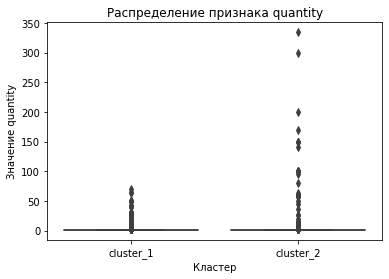

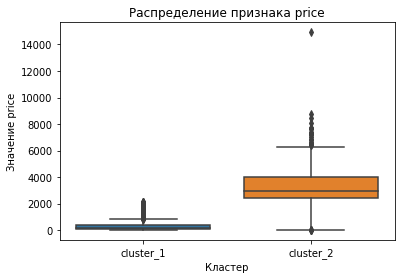

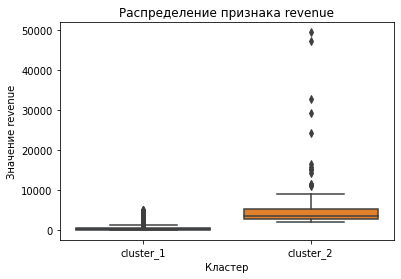

In [ ]:
# Визуализируем

cont_values = ['quantity', 'price', 'revenue']
fig, ax = plt.subplots()
for column in cont_values:
    plt.title('Распределение признака ' + column)
    sns.boxplot(x='cluster_km', y=column, data=ecommerce)
    plt.xlabel('Кластер')
    plt.ylabel('Значение ' + column)
    plt.show()

**Кластер 1** характеризуется товарами, которые:
- заказывают в небольших количествах;
- имеют небольшую стоимость до 300-400 рублей;
- дают маленькю выручку.

**Кластер 2** характеризуется товарами, которые:
- большой объем продаж;
- высокую стоимость;
- дают значительную часть выручки.

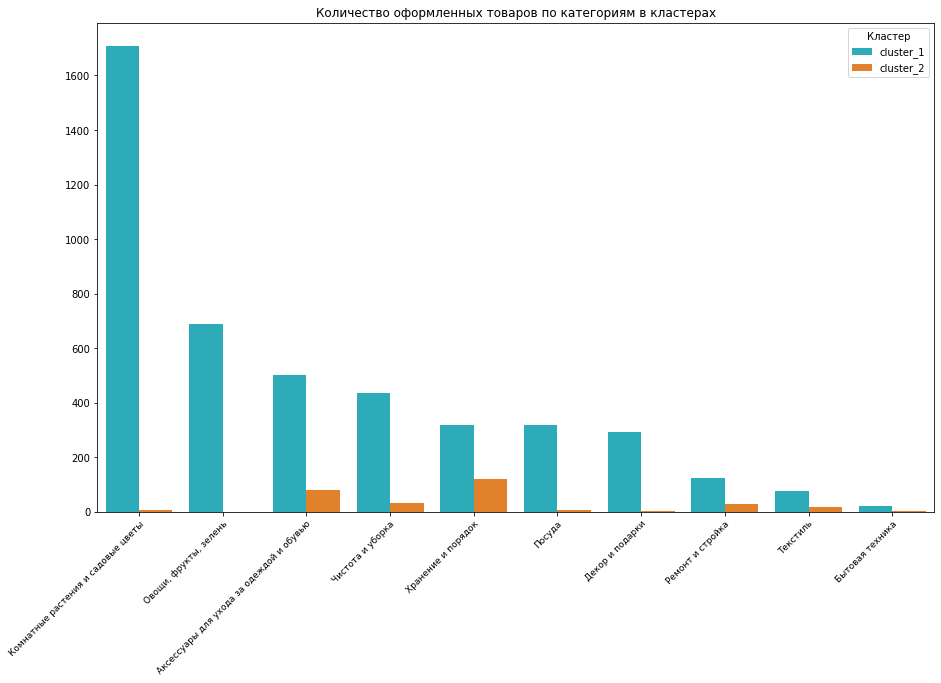

In [ ]:
# Посмотрим на количество купленных товарных наименований в кластерах по категориям

plt.figure(figsize=(15, 9))
sns.countplot(data=ecommerce, x='product_category', hue='cluster_km', palette=['C9', 'C1'], order=ecommerce['product_category'].value_counts().index)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right', fontsize=9)
plt.title('Количество оформленных товаров по категориям в кластерах')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Кластер')
plt.show()

В **Кластере 1** большая часть товара из категорий **Комнатные растения и садовые цветы** и **Овощи, фрукты, зелень**.

В **Кластере 2** большая часть товара из категории **Хранение и порядок**.

При этом и в **Кластере 1** и в **Кластере 2** в лидерах по продажам оказались одниковые категории товаров: **Аксессуары для уходи за одеждой и обувью** и **Чистота и уборка**.

## Анализ ключевых бизнес-метрик товарного ассортимента

Ранее мы предположили наличие сезонности товарного ассортимента, поэтому для дальнейшего анализа создадим столбец с временами года:

In [ ]:
# Функция, которая определяет по месяцу время года
def season_function(x):
    if '-01' in x or '02' in x or '12' in x: 
        return 'зима'
    elif '03' in x or '04' in x or '05' in x: 
        return 'весна'
    elif '06' in x or '07' in x or '08' in x:
        return 'лето'
    else:
        return 'осень'

# Применяем функцию
ecommerce['season'] = ecommerce['month'].apply(season_function)

In [ ]:
# Посмотрим на метрики пользовательской активности

dau_total = ecommerce.groupby('order_date').agg({'customer_id':'nunique'}).mean()
wau_total = ecommerce.groupby('week').agg({'customer_id':'nunique'}).mean()
mau_total = ecommerce.groupby('month').agg({'customer_id':'nunique'}).mean()

print('Среднее количество уникальных покупателей в день: {} человек.'.format(int(dau_total)))
print('Среднее количество уникальных покупателей в неделю: {} человека.'.format(int(wau_total)))
print('Среднее количество уникальных покупателей в месяць: {} человек.'.format(int(mau_total)))

Среднее количество уникальных покупателей в день: 6 человек.
Среднее количество уникальных покупателей в неделю: 43 человека.
Среднее количество уникальных покупателей в месяць: 187 человек.


In [ ]:
sticky_wau = (dau_total / wau_total) * 100
sticky_mau = (dau_total / mau_total) * 100

print('Средний процент уникальных покупателей в неделю: {:0.2f} %'.format(sticky_wau[0]))
print('Средний процент уникальных покупателей в месяц: {:0.2f} %'.format(sticky_mau[0]))

Средний процент уникальных покупателей в неделю: 15.35 %
Средний процент уникальных покупателей в месяц: 3.52 %


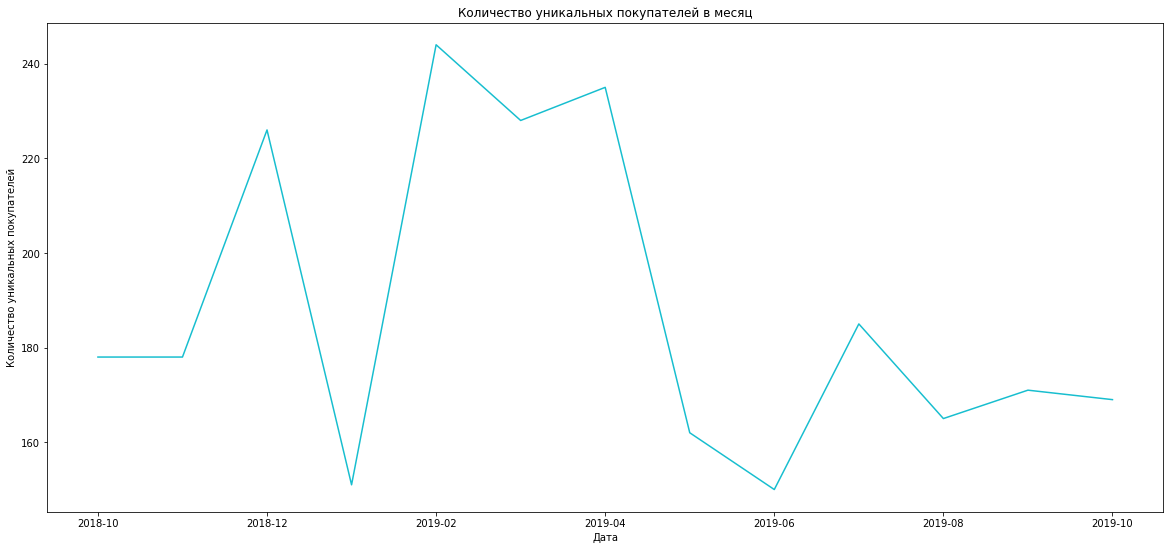

In [ ]:
# Визуализируем динамику изменения количества уникальных покупателей в месяц

ecommerce.groupby('month').agg({'customer_id':'nunique'}).plot(figsize=(20, 9), color='C9', legend=False)
plt.title('Количество уникальных покупателей в месяц')
plt.xlabel('Дата')
plt.ylabel('Количество уникальных покупателей')
plt.show()

На графике видно, что максимально высокое количество уникальных покупателей приходится на декабрь и с февраля по апрель.
Сильная же просадка по количеству уникальных пользователей наблюдается в январе и июне.

## Анализ покупателей, заказов и выручки

### Количество покупателей по временам года

Изучим разницу между количеством покупателей в разные времена года. Перед визуализацией уберем данные за октябрь 2018 года, так как наличие данных за оба октября может исказить картину:

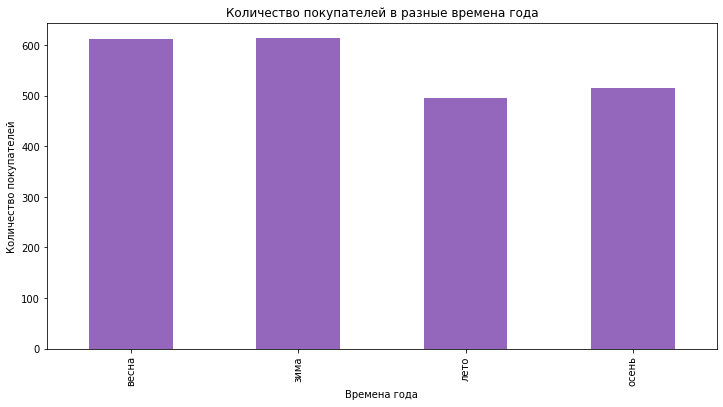

In [ ]:
ecommerce.query('month != "2018-10"').groupby('season').agg(
    {'customer_id':'nunique'}).plot(kind='bar', figsize=(12, 6), color='C4', legend=False)
plt.title('Количество покупателей в разные времена года')
plt.xlabel('Времена года')
plt.ylabel('Количество покупателей')
plt.show()

На первый взгляд разница между временами года не сильная. Весной и зимой уникальное количество пользователей одинаковое. Осенью и летом поменьше.

### Количество заказов по временам года

Делаем по аналогии количества пользователей:

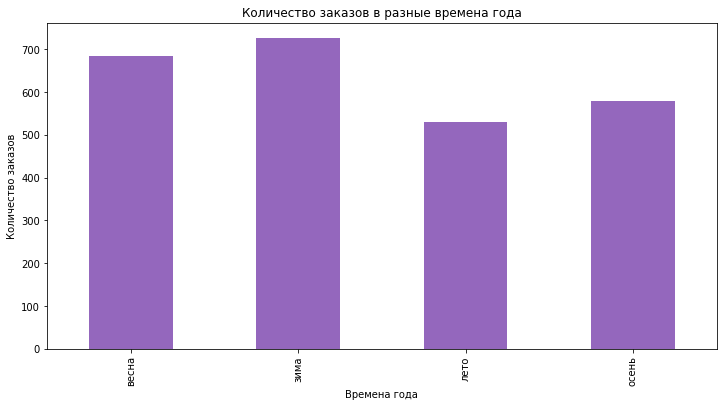

In [ ]:
ecommerce.query('month != "2018-10"').groupby('season').agg(
    {'order_id':'nunique'}).plot(kind='bar', figsize=(12, 6), color='C4', legend=False)
plt.title('Количество заказов в разные времена года')
plt.xlabel('Времена года')
plt.ylabel('Количество заказов')
plt.show()

Картина количества заказов по временам года от предыдщего графика отличается только в разнице между зимой и весной. В данном случае зима все-таки опережает весну.

### Количество заказов в каждой категории по временам года 

Делаем тоже самое, что и выше, только теперь посмотрим что происходит с товаром в разбивке на кластеры:

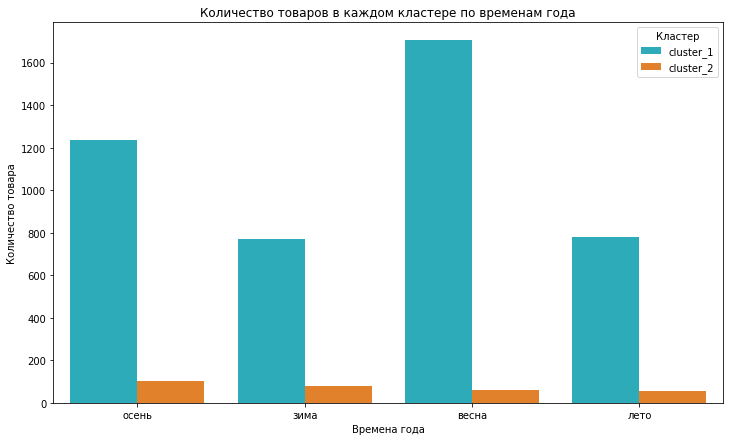

In [ ]:
plt.figure(figsize=(12, 7))
sns.countplot(data=ecommerce, x='season', hue='cluster_km', palette=['C9', 'C1'])
plt.title('Количество товаров в каждом кластере по временам года')
plt.xlabel('Времена года')
plt.ylabel('Количество товара')
plt.legend(title='Кластер')
plt.show()

В **Кластере 1** видим сильное различие по количеству товаров между **весной с осенью** и **зимой с летом**. Если во втором случае количество в сезонах одинаковое, то в первом - явный лидер **весна**. Напомним, что в этом кластере находятся дешевые товары с маленькой выручкой.

В **Кластере 2** количество заказов по всем сезонам практически одинаковое. Явный лидер тут уже **осень**. Напомним, что в этом кластере находятся дорогие товары с большой выручкой.

### Количество заказов в каждой категории в разрезе по кластерам и временам года

Наша основная задача этого исследования - понять какие категории товаров сделать основными, а какие дополнительными. Для этого разберемся какие категории товаров в разные времена года приносят максимальную выручку.

Построим *heatmap* по количеству уникальных заказов в каждой категории в разрезе по кластерам и временам года:

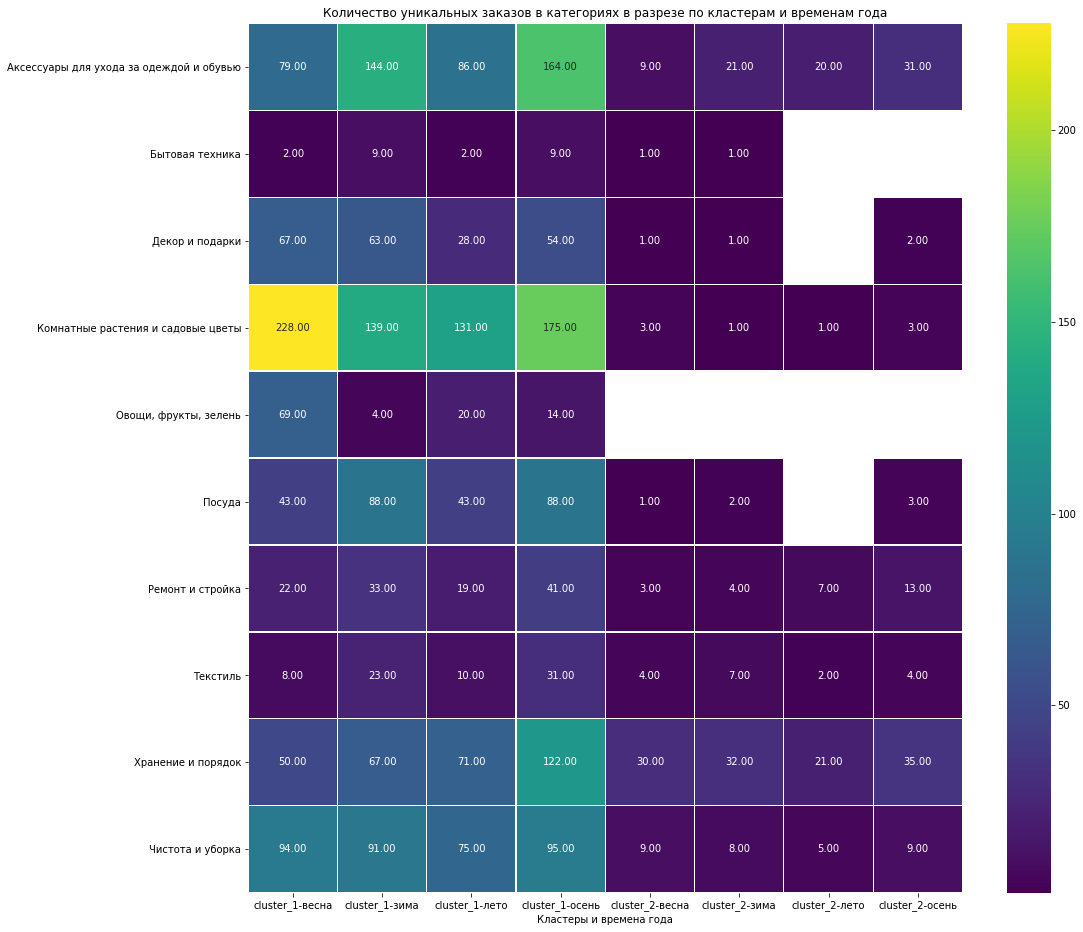

In [ ]:
unique_orders = ecommerce.pivot_table(
    index='product_category', columns=['cluster_km', 'season'], values='order_id', aggfunc='nunique')

plt.figure(figsize=(16, 16))
sns.heatmap(unique_orders, annot=True, fmt='.2f', linewidth=0.1, cmap='viridis')
plt.title('Количество уникальных заказов в категориях в разрезе по кластерам и временам года')
plt.xlabel('Кластеры и времена года')
plt.ylabel('')
plt.show()

**ВЕСНА:**
- В **Кластер 1** с большим отрывом лидирует категория **Комнатные растения и садовые цветы**.
- В **Кластер 2** также с большим отрывом лидирует категория **Хранение и порядок**.

**ЛЕТО:**
- В **Кластер 1** продолжает лидировать категория **Комнатные растения и садовые цветы**.
- В **Кластер 2** в лидерах уже находятся две категории: **Хранение и порядок** и **Аксессуары для ухода за одеждой и обувью**.

**ОСЕНЬ:**
- В **Кластер 1** на первом месте продолжает быть категория **Комнатные растения и садовые цветы**, но ее уже догоняет категория **Аксессуары для ухода за одеждой и обувью**.
- В **Кластер 2** в лидерах стабильно **Хранение и порядок** и **Аксессуары для ухода за одеждой и обувью**.

**ЗИМА:**
- В **Кластер 1** лидеры по категориям те же **Комнатные растения и садовые цветы** и **Аксессуары для ухода за одеждой и обувью**, но аксессуары по продажам уже обгоняют растения.
- В **Кластер 2** стабильность: **Хранение и порядок** и **Аксессуары для ухода за одеждой и обувью**.

### Наибольшая выручка

С категориями лидерами по продажам мы определились выше, теперь выясним финансовую сторону вопроса. Какие категории и в какой период приносят наибольшую выручку?

- БЕЗ РАЗБИВКИ НА КЛАСТЕРЫ

In [ ]:
print('Суммарная выручка с продаж за период с 1 октября 2018 по 31 октября 2019 составляет {} рублей'.format(
    ecommerce['revenue'].sum()))

revenue_avg = ecommerce.groupby('customer_id').agg({'revenue':'sum'}).mean()
print('Средний чек заказа: {} рублей'.format(int(revenue_avg)))

Суммарная выручка с продаж за период с 1 октября 2018 по 31 октября 2019 составляет 3411515.0 рублей
Средний чек заказа: 1425 рублей


Посмотрим как меняется выручка по месяцам выручки за день, месяц, сезон, а также в разрезе по кластерам. Также оценим выручку в различных категориях товаров

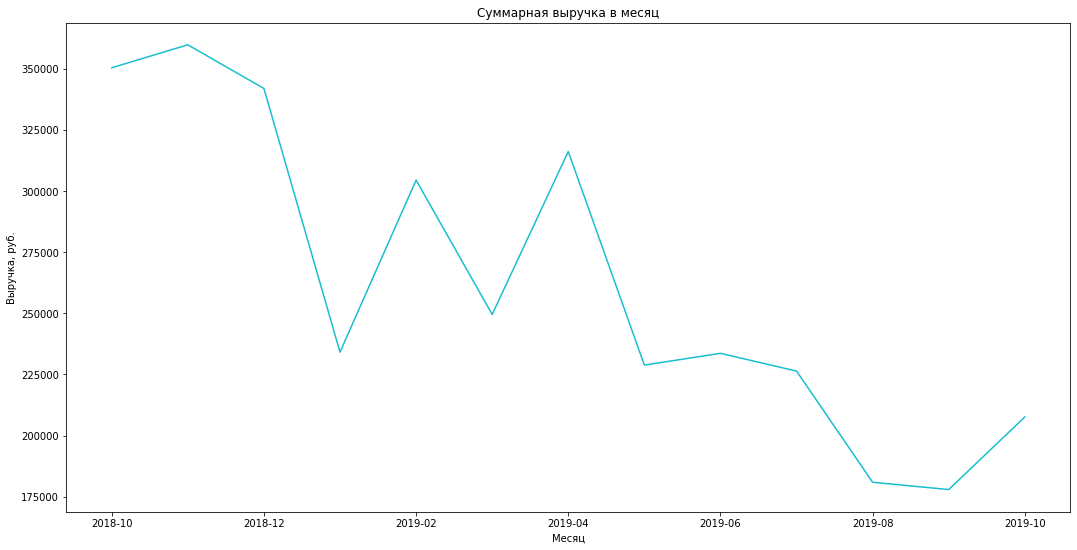

In [ ]:
# Динамика суммарной выручки в месяц

revenue_per_month = ecommerce.pivot_table(index=['month', 'cluster_km'], values=['customer_id', 'revenue', 'order_id'], aggfunc={
    'customer_id':'nunique', 'revenue':'sum', 'order_id':'nunique'}).reset_index(level='cluster_km')

revenue_per_month.groupby('month')['revenue'].sum().plot(figsize=(18, 9), color='C9')
plt.title('Суммарная выручка в месяц')
plt.xlabel('Месяц')
plt.ylabel('Выручка, руб.')
plt.show()

- **Наибольшая выручка:** ноябрь, декабрь, февраль, апрель.
- **Наименьшая выручка:** январь, март, июнь, июль.
- **Максимально неприбыльные месяцы**: август и сентябрь.

Еще интересный момент, что **октябрь 2018** гораздо прибыльнее **октября 2019**.

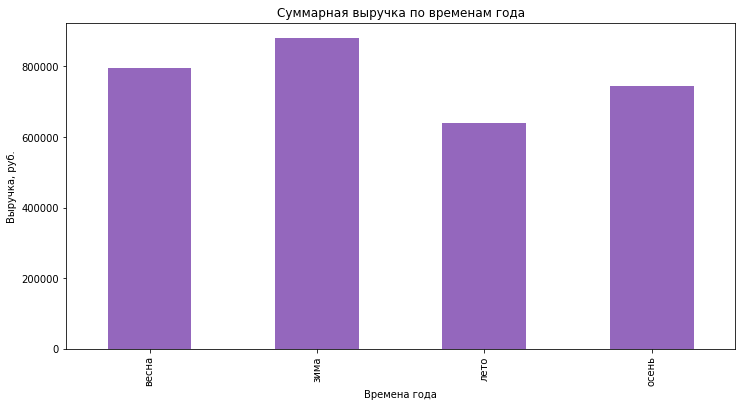

In [ ]:
# Динамика суммарной выручки по временам года без учета октября 2018

revenue_per_season = ecommerce.query('month != "2018-10"').pivot_table(index=['season', 'cluster_km'], values=['customer_id', 'revenue', 'order_id'], aggfunc={
    'customer_id':'nunique', 'revenue':'sum', 'order_id':'nunique'}).reset_index()

revenue_per_season.groupby('season')['revenue'].sum().plot(kind='bar', figsize=(12, 6), color='C4', legend=False)
plt.title('Суммарная выручка по временам года')
plt.xlabel('Времена года')
plt.ylabel('Выручка, руб.')
plt.show()

От наибольшей выручке по времени года к наименьшей:
**зима** -> **весна** -> **осень** -> **лето**.

- С РАЗБИВКОЙ НА КЛАСТЕРЫ

Посмотрим теперь какой из кластеров в какие месяцы и какое время года приносит наибольшие выручки:

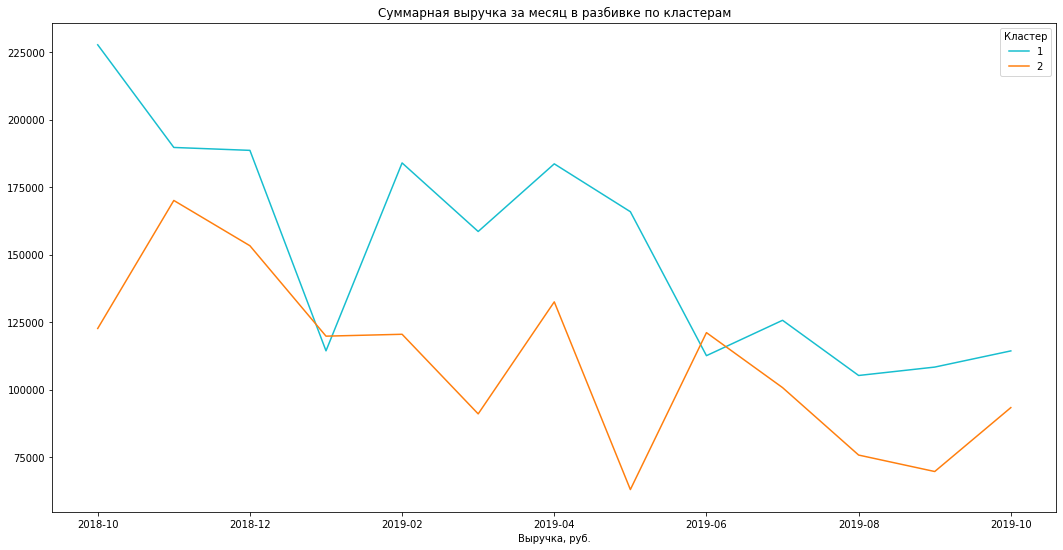

In [ ]:
plt.figure(figsize=(18, 9))
revenue_per_month[revenue_per_month['cluster_km'] == 'cluster_1']['revenue'].plot(color='C9', label=1)
revenue_per_month[revenue_per_month['cluster_km'] == 'cluster_2']['revenue'].plot(color='C1', label=2)
plt.title('Суммарная выручка за месяц в разбивке по кластерам')
plt.xlabel('Выручка, руб.')
plt.legend(title='Кластер')
plt.show()

В основном выручка по месяцам дорогих товаров ниже выручки дешевых товаров. Для более наглядной картины, посмотрим на выручку кластеров по дням:

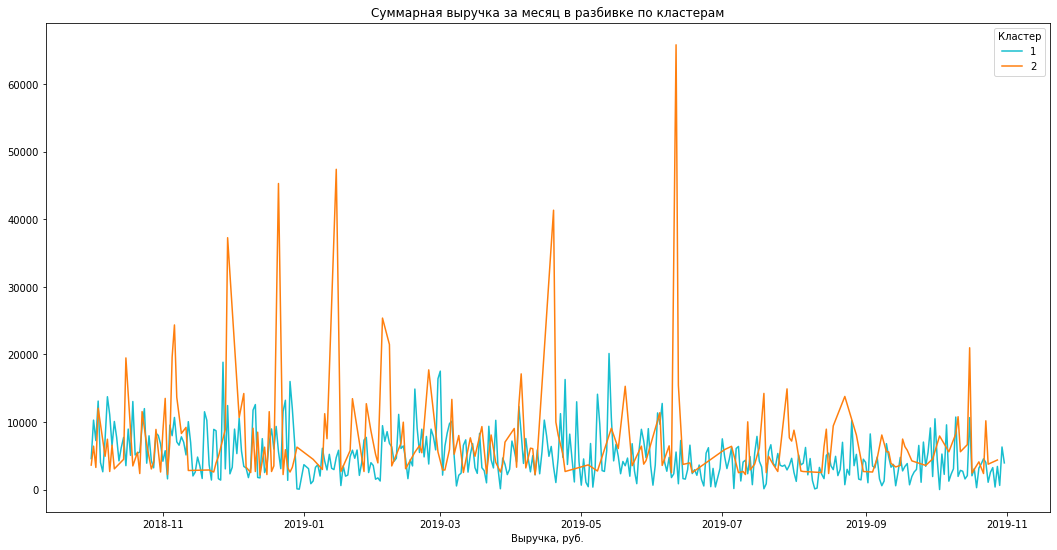

In [ ]:
revenue_per_day = ecommerce.pivot_table(index=['order_date', 'cluster_km'], values=['customer_id', 'revenue'], aggfunc={
    'customer_id':'nunique', 'revenue':'sum'}).reset_index(level='cluster_km')

plt.figure(figsize=(18, 9))
revenue_per_day[revenue_per_day['cluster_km'] == 'cluster_1']['revenue'].plot(color='C9', label=1)
revenue_per_day[revenue_per_day['cluster_km'] == 'cluster_2']['revenue'].plot(color='C1', label=2)
plt.title('Суммарная выручка за месяц в разбивке по кластерам')
plt.xlabel('Выручка, руб.')
plt.legend(title='Кластер')
plt.show()

Картина прояснилась: заказы дорогих товаров приносят большую выручку на коротком временном промежутке, а дешевые товары на длинном.

Осталось посмотреть что происходит с выручкой в кластерах в зависимости от времени года:

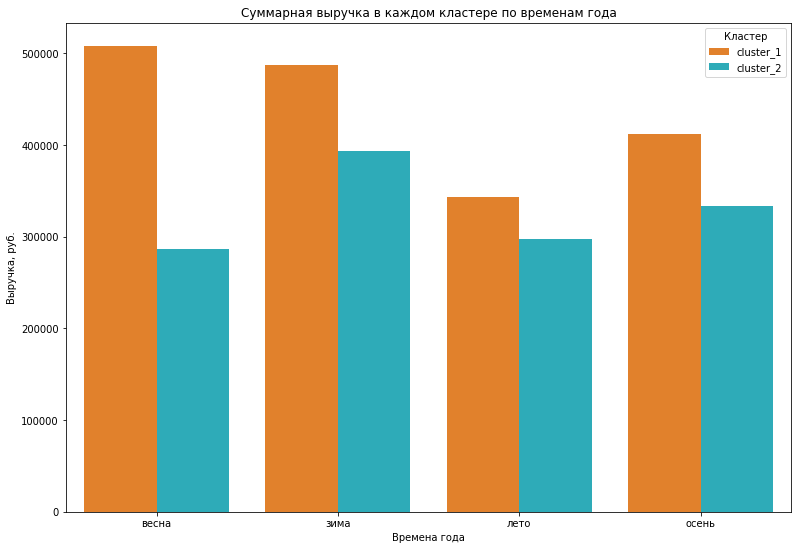

In [ ]:
plt.figure(figsize=(13, 9))
sns.barplot(data=revenue_per_season, y='revenue', x='season', hue='cluster_km', palette=['C1', 'C9'])
plt.xlabel('Времена года')
plt.ylabel('Выручка, руб.')
plt.title('Суммарная выручка в каждом кластере по временам года')
plt.legend(title='Кластер')
plt.show()

По выручке в каждом сезоне определенно лидирует **Кластер 1** с наиболее дешевыми товарами.

Построим *heatmap* по суммарной выручки каждой категории в разбивке по кластерам и временам года:

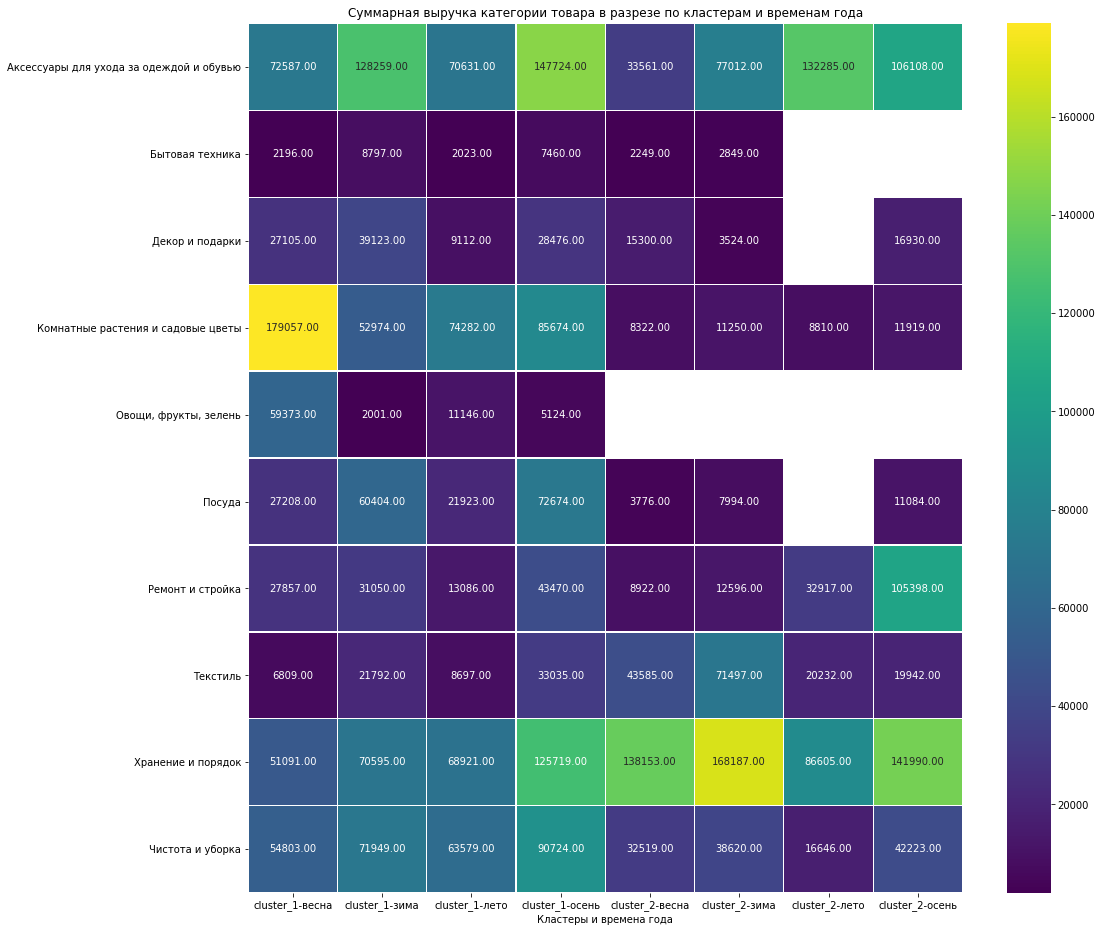

In [ ]:
revenue_per_category = ecommerce.pivot_table(
    index='product_category', columns=['cluster_km', 'season'], values='revenue', aggfunc='sum')

plt.figure(figsize=(16, 16))
sns.heatmap(revenue_per_category, annot=True, fmt='.2f', linewidth=0.1, cmap='viridis')
plt.title('Суммарная выручка категории товара в разрезе по кластерам и временам года')
plt.xlabel('Кластеры и времена года')
plt.ylabel('')
plt.show()

Видим уже знакомую нам картину! Весной в обоих кластерах так и остаются бесспорными лидерами **Комнатные и садовые растения** в **Кластере 1** и **Хранение и порядок** в **Кластере 2**. В остальных сезонах есть некоторые отличия выручки от количества заказов.

Отличия в **Кластере 1**:
1. Летом два уверенных лидеры по выручке: **Комнатные растения и садовые цветы** и **Аксессуары для ухода за одеждой и обувью**. По количеству выручки аксессуары догнали растения только осенью.
2. Осенью в лидерах по выручке оказываются **Аксессуары для ухода за одеждой и обувью** и **Хранение и порядок**. А растения занимают лишь 4 строчку по выручке.
3. Зимой с большим отрывом от остальных категорий лидирует **Аксессуары для ухода за одеждой и обувью**.

Отличия в **Кластере 2**:
1. Летом единственный заметный лидер - **Аксессуары для ухода за одеждой и обувью**.
2. Осенью к предыдущим лидерам по выручке **Хранение и порядок** и **Аксессуары для ухода за одеждой и обувью**, с небольшим отрывом к ним присоединяется категория **Ремонт и стройка**.
3. Зима же радует большой выручкой только по категории **Хранение и порядок**.

### Наибольший средний чек

Напоследок по аналогии с выручкой изучим средний чек заказа за весь период и в разрезе по категориям и кластерам.

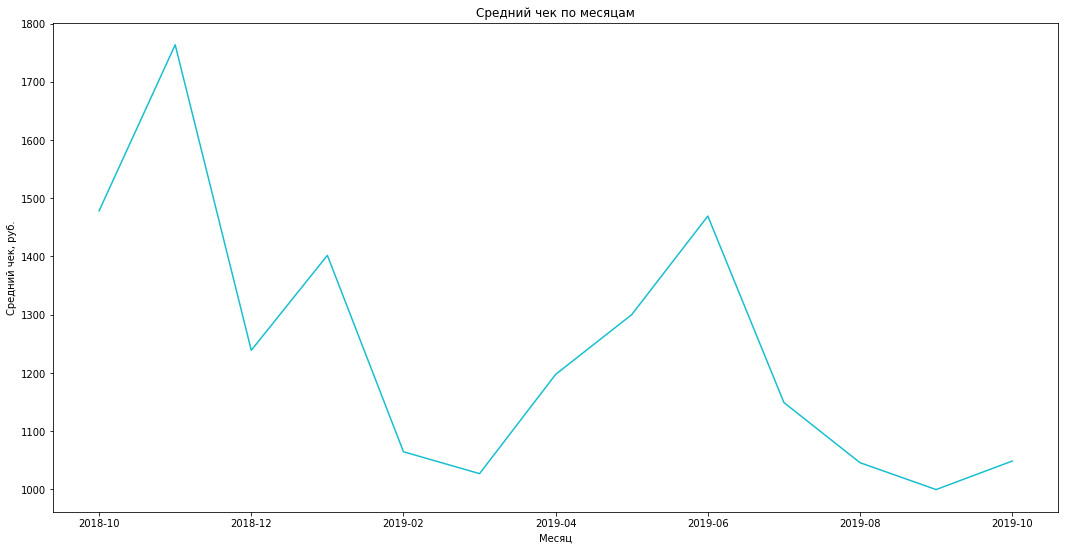

In [ ]:
# Динамика среднего чека по месяцам

avg_check = ecommerce.groupby('month').agg({'revenue':'sum', 'order_id':'nunique'})
avg_check['revenue_per_order'] = avg_check['revenue'] / avg_check['order_id']

avg_check.plot(figsize=(18, 9), y='revenue_per_order', color='C9', legend=False)
plt.title('Средний чек по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средний чек, руб.')
plt.show()

График среднего чека по месяцам более растянутый и в некотором роде сглаженый в сравнение с графиком выручки. Но самое интересное - это то, что средний чек выше в тех месяцах, где суммарная выручка была ниже. А низкий средний чек - в месяцах, где высокая суммарная выручка.

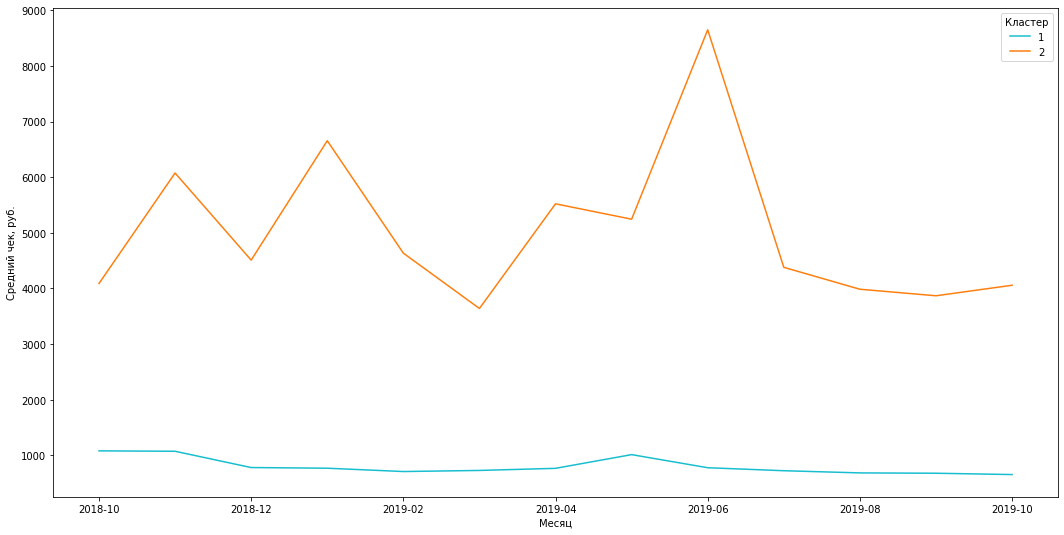

In [ ]:
# Средний чек в каждом кластере по месяцам

avg_check_cluster = ecommerce.groupby(['month', 'cluster_km']).agg(
    {'revenue':'sum','customer_id':'nunique','order_id':'nunique'}).reset_index(level='cluster_km')
avg_check_cluster['revenue_per_order'] = avg_check_cluster['revenue'] / avg_check_cluster['order_id']

plt.figure(figsize=(18, 9))
avg_check_cluster[avg_check_cluster['cluster_km'] == 'cluster_1']['revenue_per_order'].plot(color='C9', label=1)
avg_check_cluster[avg_check_cluster['cluster_km'] == 'cluster_2']['revenue_per_order'].plot(color='C1', label=2)
plt.legend(title='Кластер')
plt.xlabel('Месяц')
plt.ylabel('Средний чек, руб.')
plt.show()

Предсказуемая картина: средний чек, естественно, выше в том кластере, где товары дороже.

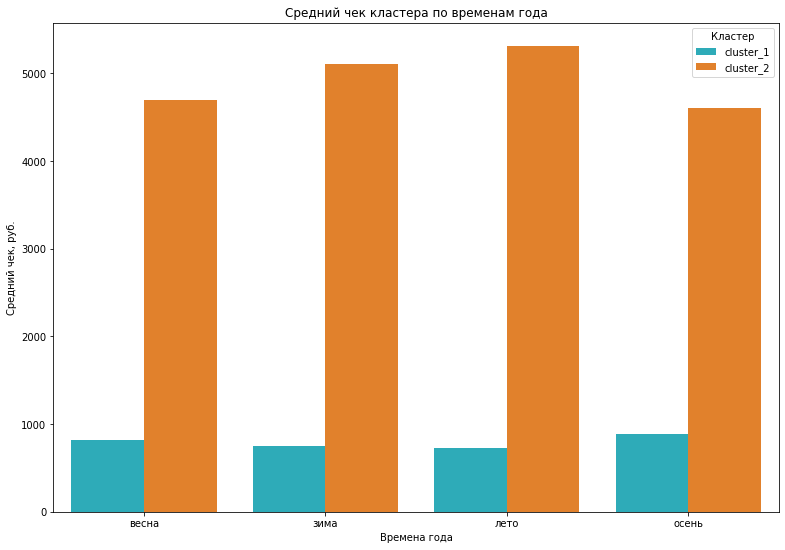

In [ ]:
# Средний чек кластера по временам года

avg_check_cluster_season = ecommerce.groupby(['season', 'cluster_km']).agg(
    {'revenue':'sum', 'order_id':'nunique'}).reset_index(level='cluster_km').reset_index()
avg_check_cluster_season['revenue_per_order'] = avg_check_cluster_season['revenue'] / avg_check_cluster_season['order_id']

plt.figure(figsize=(13, 9))
sns.barplot(data=avg_check_cluster_season, y='revenue_per_order', x='season', hue='cluster_km', palette=['C9', 'C1'])
plt.xlabel('Времена года')
plt.ylabel('Средний чек, руб.')
plt.title('Средний чек кластера по временам года')
plt.legend(title='Кластер')
plt.show()

Средний чек на дешевые товары от сезона к сезону почти не меняется и держится на низкой отметке. Средний чек по дорогим товарам выше всего летом, но и другие сезона отстали не сильно.

**Вывод по анализу покупателей, заказам и выручки:**

1. **Пользовательские метрики:**
- Среднее количество уникальных пользователей в день: **6 человек**.
- Среднее количество уникальных пользователей в неделю: **43 человека**.
- Среднее количество уникальных пользователей в месяц: **187 человек**.

**Средний процент уникальных покупателей за неделю:** 15.35%
**Средний процент уникальных покупателей за месяц:** 3.52%

2. **Сезонность количества заказов:**
ПО МЕСЯЦАМ
- В **Кластере 1** сильное различие по количеству товаров между **весной с осенью** и **зимой с летом**. Если во втором случае количество в сезонах одинаковое, то в первом - явный лидер **весна**.
- В **Кластере 2** количество заказов по всем сезонам практически одинаковое, но явный лидер - **осень**.

ПО СЕЗОНАМ
- **Весной** в **Кластере 1** с большим отрывом лидирует категория **Комнатные растения и садовые цветы**, а в **Кластере 2** также с большим отрывом лидирует категория **Хранение и порядок**.
- **Летом** в **Кластере 1** продолжает лидировать категория **Комнатные растения и садовые цветы**, а в **Кластере 2** в лидерах находятся две категории: **Хранение и порядок** и **Аксессуары для ухода за одеждой и обувью**.
- **Осенью** в **Кластере 1** лидируют 2 категории: **Комнатные растения и садовые цветы** и **Аксессуары для ухода за одеждой и обувью**, в **Кластере 2** в лидерах стабильно находятся **Хранение и порядок** и **Аксессуары для ухода за одеждой и обувью**.
- **Зимой** в **Кластере 1** лидеры по категориям те же, что и осенью **Комнатные растения и садовые цветы** и **Аксессуары для ухода за одеждой и обувью**, но аксессуары по продажам уже обгоняют растения. В **Кластере 2** стабильность: **Хранение и порядок** и **Аксессуары для ухода за одеждой и обувью**.

3. **Сезонность выручки:**

**Суммарная выручка магазина за весь период:** 3 411 515 рублей.

ПО МЕСЯЦАМ
- **Наибольшая выручка** магазина приходится на зимний сезон. В основном благодаря **ноябрю** и **декабрю**, а **январь** - дает **наименьшую выручку**.
- **Весна** также приносит **большую выручку** магазину за счет **февраля** и **апреля**, при этом **март** относится к месяцам с **наименьшой выручкой**.
- **Лето** и **Осень** в сравнении с зимой и весной, **неприбыльне** сезоны. **Наименьшую выручку** магазин получает с **июня** по **сентябрь**.

ПО СЕЗОНАМ
- **Весной** в обоих кластерах бесспорными лидерами являются категории **Комнатные и садовые растения** в **Кластере 1** и **Хранение и порядок** в **Кластере 2**.
- **Летом** в **Кластере 1** два уверенных лидеры по выручке: **Комнатные растения и садовые цветы** и **Аксессуары для ухода за одеждой и обувью**. По количеству заказов аксессуары догнали растения только осенью. В **Кластере 2** единственный заметный лидер - **Аксессуары для ухода за одеждой и обувью**.
- **Осенью** в **Кластере 1** в лидерах по выручке категории **Аксессуары для ухода за одеждой и обувью** и **Хранение и порядок**. А растения занимают лишь 4 строчку по выручке. В **Кластере 2** в лидерах аж 3 категории товаров: **Хранение и порядок**, **Аксессуары для ухода за одеждой и обувью** и **Ремонт и стройка**.
- **Зимой** в **Кластере 1** с большим отрывом от остальных категорий лидирует **Аксессуары для ухода за одеждой и обувью**. **Кластер 2** радует большой выручкой только по категории **Хранение и порядок**

3. **Средний чек** за весь исследуемый период сильно снизился.

**Средний чек заказа за весь период:** 1 425 рублей.

ПО КАТЕГОРИЯМ
- **Осенью** и **Зимой** средний чек был чуть выше среднего - **1 500 рублей**. При этом, с **декабря** по **март** средний чек значительно упал до отметки **1 020 рублей**.
- **Летом** в **июне** средний чек вернулся к своему стандартному показателю, но затем снова начал падать. В **сентябре** средний чек достиг своих минимальных значений - ниже **1 000 рублей**.

ПО КЛАСТЕРАМ сезонность практически не влияет на показатели среднего чека:
- Средний чек в **Кластере 1** за весь период не поднимался выше **1 000 рублей**.
- Средний чек в **Кластере 2** за весь период около **5 000 рублей**.


### Самые прибыльные товары

- **ТОП-5** товаров в каждой из 10 категорий, которые за весь период принесли наибольшую выручку магазину:

In [ ]:
category = ecommerce['product_category'].unique()

for i in category:
    display(i, ecommerce[ecommerce['product_category'] == i].groupby('product').agg(
        {'order_id':'nunique', 'quantity':'sum', 'revenue':'sum'}).sort_values(by='revenue', ascending=False).head(5))

'Комнатные растения и садовые цветы'

,order_id,quantity,revenue
product,,,
спатифиллум шопен d-12 см,2,46,11512.0
пеларгония зональная диам. 12 см сиреневый полумахровый,52,63,10780.0
пеларгония розебудная red pandora укорененный черенок,64,79,10655.0
пеларгония зональная диам. 12 см красная махровая,21,63,10514.0
эвкалипт гунни d-17 см h-60 см,6,6,9866.0


'Аксессуары для ухода за одеждой и обувью'

,order_id,quantity,revenue
product,,,
вешалки мягкие для деликатных вещей 3 шт шоколад,2,335,49596.0
гладильная доска ника blues 124х46 см 5757,7,7,17786.0
сушилка meliconi stendy junior,3,3,16782.0
сушилка уличная leifheit 85210 linomatic v 400 40 м 175х237х237 см зеленая,1,1,14917.0
гладильная доска colombo avantgard 120х40 см,3,3,14712.0


'Хранение и порядок'

,order_id,quantity,revenue
product,,,
сумка-тележка 2-х колесная gimi argo синяя,47,47,50405.0
тележка багажная delta тбр-22 синий грузоподъемность 20 кг сумка и 50 кг каркас россия,3,59,33992.0
"сумка-тележка хозяйственная andersen scala shopper plus, lini, синяя 133-108-90",5,5,28045.0
сумка-тележка 3-х колесная gimi tris floral синяя,7,7,18893.0
"сумка-тележка хозяйственная andersen treppensteiger scala shopper, hera, черная 119-004-80",3,3,18560.0


'Текстиль'

,order_id,quantity,revenue
product,,,
простынь вафельная 200х180 см wellness rw180-01 100% хлопок,2,30,53232.0
салфетка protec textil polyline 30х43 см аметист белая 6230,4,80,15700.0
одеяло wellness t142 белое темостеганое 140х205 см чехол 100% полиэстер 200 г/м 4690659000306,1,10,15680.0
"наматрацник natures бархатный бамбук бб-н-1-2 односпальный, 100% хлопок, стеганый 90х200 см, с резинкой по углам, белый",1,12,14196.0
скатерть круглая d-175 см 50% полиэстер 50% хлопок белая wellness mld-187-эстель*01,1,10,11400.0


'Овощи, фрукты, зелень'

,order_id,quantity,revenue
product,,,
"рассада зелени для кухни базилик тонус, кассета по 6шт",10,14,2366.0
рассада зелени для кухни розмарина в горшке диам. 9 см,14,15,1705.0
рассада зелени для кухни розмарин блю лагун диам. 9 см,13,13,1554.0
"рассада зелени для кухни базилик арарат, кассета по 6шт",9,9,1521.0
рассада зелени для кухни мята морокан диам. 9 см,8,10,1200.0


'Декор и подарки'

,order_id,quantity,revenue
product,,,
муляж яблоко 9 см красное,6,618,32702.0
новогоднее дерево ель сербская d-21 см h-60 см,8,9,9441.0
муляж яблоко зеленый 9 см полиуретан,6,148,8132.0
муляж банан желтый 21 см полиуретан,6,109,5831.0
муляж лимон желтый 9 см полиуретан,5,92,4998.0


'Ремонт и стройка'

,order_id,quantity,revenue
product,,,
набор ножей attribute chef 5 предметов akf522,1,64,29248.0
"урна уличная ""гео"", hobbyka/хоббика, 59*37,5см, сталь",1,5,24370.0
стремянки colombo leonardo 3 ступени g300a03w черая 3649,2,2,7948.0
стремянка 7 ступенчатая hailo 8040-707 xxl 13 см алюминиевая с лотком для инструментов,1,1,7724.0
урна уличная стальная сальвадор 02.021.0 46х110 см,1,1,7349.0


'Посуда'

,order_id,quantity,revenue
product,,,
"модульная стеклянная банка 1,1л, 298264, brabantia,",1,7,5775.0
"тарелка суповая luminarc океан эклипс 20,5 см l5079",2,60,4680.0
кружка с трубочкой attribute мяч 500 мл jar501,1,60,4560.0
"ковш пластмассовый полимербыт с215, 1,5 л 1406006",2,69,4516.0
"таз пластмассовый 40,0 л пищевой овальный (иж), 1404094",5,9,3636.0


'Чистота и уборка'

,order_id,quantity,revenue
product,,,
"веник сорго с деревянной ручкой с 4-мя швами, rozenbal, r206204",2,37,20010.0
коврик придверный attribute nature кокосовый 60x40 см amc015,4,54,16888.0
"ведро для мусора hailo 0516-570 16 л, бежевый",2,2,7498.0
автоматическая щетка leifheit для мытья окон с ручкой 43 см. 51114,1,1,7229.0
"коврик для ванной прямоугольный, 4.5см. shaggy 70х100см голубой, 603001-003",2,3,6297.0


'Бытовая техника'

,order_id,quantity,revenue
product,,,
"весы напольные электронные soehnle pino white, 63747",1,1,2849.0
"весы электронные кухонные soehnle (круглые,20 см. стеклянные) серебро 5кг/1гр. 66161",2,2,2548.0
пылесос delta dl-0831 красный 1300 вт мешок для сбора пыли 1 в подарок мощность всасывания 200 вт,1,1,2249.0
пылесос delta dl-0835 синий 1600 вт мешок для сбора пыли 1 в подарок мощность всасывания 300 вт,1,1,1994.0
чайник электрический василиса т33-2000 нержавеющая сталь красный 2000 вт 2 л,2,2,1498.0


- **ТОП-10** сезонных товаров, которые принесли наибольшую выручку магазину:

In [ ]:
season = ecommerce['season'].unique()
for i in season:
    display(i, ecommerce[ecommerce['season'] == i].groupby('product').agg(
        {'order_id':'nunique', 'quantity':'sum', 'revenue':'sum'}).sort_values(by='revenue', ascending=False).head(10))

'осень'

,order_id,quantity,revenue
product,,,
набор ножей attribute chef 5 предметов akf522,1,64,29248.0
"урна уличная ""гео"", hobbyka/хоббика, 59*37,5см, сталь",1,5,24370.0
муляж яблоко 9 см красное,5,318,17402.0
сумка-тележка 2-х колесная gimi argo синяя,13,13,13941.0
сумка-тележка хозяйственная rolser imx005 marengo logic dos+2 серая,2,2,12014.0
сумка-тележка хозяйственная gimi market синяя,5,5,9370.0
"веник сорго с деревянной ручкой с 4-мя швами, rozenbal, r206204",1,17,9010.0
"сумка-тележка хозяйственная rolser jet joy синяя, jet001 azul joy",3,3,8772.0
сумка-тележка 2-х колесная gimi galaxy черная,3,3,8397.0


'зима'

,order_id,quantity,revenue
product,,,
простынь вафельная 200х180 см wellness rw180-01 100% хлопок,2,30,53232.0
тележка багажная delta тбр-22 синий грузоподъемность 20 кг сумка и 50 кг каркас россия,2,58,33355.0
сумка-тележка 2-х колесная gimi argo синяя,16,16,16898.0
мусорный контейнер hailo bigbin swing 45 0845-010 45 л хром,1,3,16536.0
спатифиллум шопен d-12 см,1,45,11250.0
"веник сорго с деревянной ручкой с 4-мя швами, rozenbal, r206204",1,20,11000.0
"сумка-тележка хозяйственная andersen scala shopper plus, lini, синяя 133-108-90",2,2,10498.0
новогоднее дерево ель сербская d-21 см h-60 см,8,9,9441.0
сумка-тележка 2-х колесная gimi galaxy голубая,3,3,8547.0


'весна'

,order_id,quantity,revenue
product,,,
одеяло wellness t142 белое темостеганое 140х205 см чехол 100% полиэстер 200 г/м 4690659000306,1,10,15680.0
муляж яблоко 9 см красное,1,300,15300.0
салфетка protec textil polyline 30х43 см аметист белая 6230,2,74,14386.0
"наматрацник natures бархатный бамбук бб-н-1-2 односпальный, 100% хлопок, стеганый 90х200 см, с резинкой по углам, белый",1,12,14196.0
"сумка-тележка хозяйственная andersen scala shopper plus, lini, синяя 133-108-90",2,2,12298.0
"сумка-тележка хозяйственная andersen scala shopper, elba, бирюзовая 112-051-90",3,3,11361.0
"сумка-тележка хозяйственная andersen scala shopper, petit, черная 112-010-80",2,2,10498.0
сумка-тележка 2-х колесная gimi argo синяя,9,9,9783.0
"сумка-тележка хозяйственная andersen royal shopper, hera, синяя 166-004-90",1,1,8737.0


'лето'

,order_id,quantity,revenue
product,,,
вешалки мягкие для деликатных вещей 3 шт шоколад,2,335,49596.0
сушилка уличная leifheit 85210 linomatic v 400 40 м 175х237х237 см зеленая,1,1,14917.0
гладильная доска ника blues 124х46 см 5757,5,5,12635.0
скатерть круглая d-175 см 50% полиэстер 50% хлопок белая wellness mld-187-эстель*01,1,10,11400.0
сумка-тележка 2-х колесная gimi argo синяя,9,9,9783.0
"сумка-тележка хозяйственная andersen scala shopper, lini, синяя 112-108-90",2,2,9148.0
скатерть 180 см wellness wtd180-лион*01 100% полиэстер,1,8,8832.0
спатифиллум свит лауретта d-21 см h-95 см,1,5,8810.0
сумка-тележка 3-х колесная gimi tris floral синяя,3,3,8097.0


## Статистический анализ

### Взаимосвязь кластеров: матрица корреляции

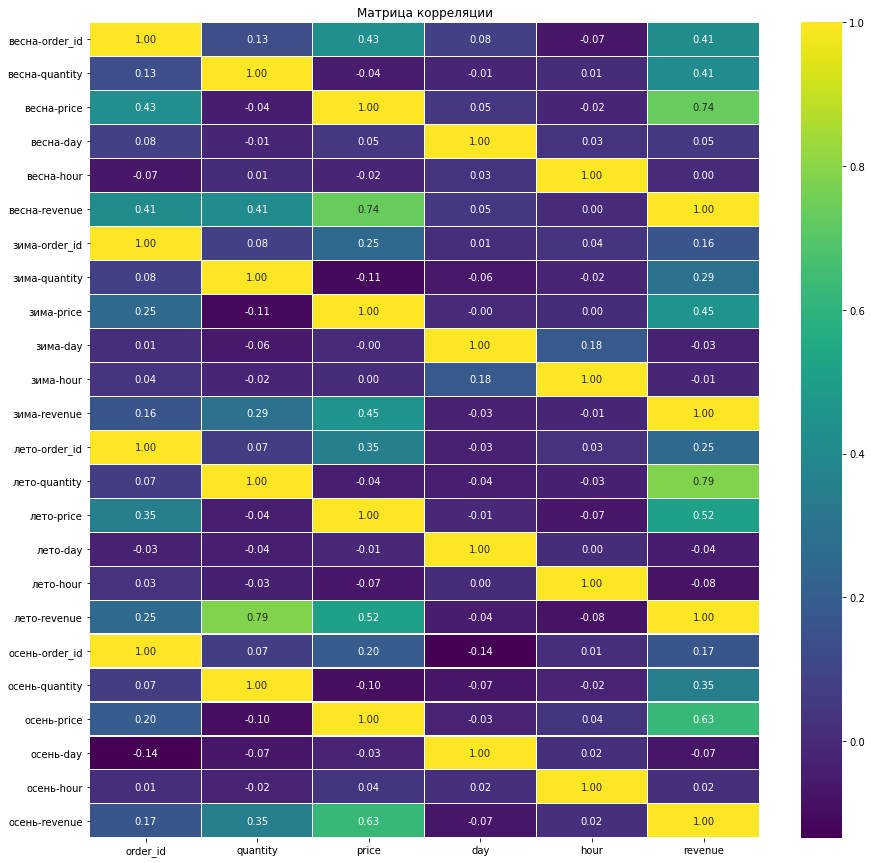

In [ ]:
# Построим матрицу корреляции для оценки взаимосвязей между кластерами и метриками

cm = ecommerce.groupby(['season']).corr()
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, linewidth=0.1, fmt='.2f', cmap='viridis')
plt.ylabel('')
plt.title('Матрица корреляции')
plt.show()

По матрице видно, что на показатели кластеров влияют сезонность, выручка, цена товара. Есть корреляция между количеством купленных товаров и суммарной выручкой.

### Статистический тест на равенство выручек кластеров

Сформулируем и проверим гипотезы о равенстве кластеров по выручке и среднему чеку.

Для начала проверив гипотезу о равенстве выручки кластеров:
- H0 - выручка **Кластера 1** и выручка **Кластера 2** одинаковые.
- H1 - выручка **Кластера 1** и выручка **Кластера 2** различаются.

α=5%

In [ ]:
# Проверим равенство дисперсий кластеров

cluster_1_revenue = ecommerce.query('cluster_km == "cluster_1"')['revenue']
cluster_2_revenue = ecommerce.query('cluster_km == "cluster_2"')['revenue']

print('Дисперсия выручки кластера 1: {}'.format(np.var(cluster_1_revenue, ddof=1)))
print('Дисперсия выручки кластера 2: {}'.format(np.var(cluster_2_revenue, ddof=1)))
print('Соотношение дисперсий 1-го и 2-го кластеров: {}'.format((np.var(cluster_2_revenue, ddof=1))/(np.var(cluster_1_revenue, ddof=1))))

Дисперсия выручки кластера 1: 314853.2585179409
Дисперсия выручки кластера 2: 24360923.114828374
Соотношение дисперсий 1-го и 2-го кластеров: 77.3723074345767


Соотношение дисперсий сильно высокое, поэтому при проведении теста будем указывать параметр *equal_var*.

In [ ]:
alpha = .05

results = st.ttest_ind(
    cluster_1_revenue, 
    cluster_2_revenue, 
    equal_var=False)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  2.857109506349008e-39
Отвергаем нулевую гипотезу


Отвергая нулевую гипотезу, мы понимаем, что между выручками **Кластера 1** и **Кластера 2** есть значимая разница.

Посмотрим на среднюю выручку обоих кластеров:

In [ ]:
print('Средняя выручка по товарам кластера 1: {:.2f}'.format(np.mean(cluster_1_revenue)))
print('Средняя выручка по товарам кластера 2: {:.2f}'.format(np.mean(cluster_2_revenue)))
print('Соотношение между средними выручками по товарам 1-го и 2-го кластеров: {:.2f}'.format(np.mean(cluster_2_revenue) / np.mean(cluster_1_revenue)))

Средняя выручка по товарам кластера 1: 441.04
Средняя выручка по товарам кластера 2: 4808.74
Соотношение между средними выручками по товарам 1-го и 2-го кластеров: 10.90


Средние выручки по товарам отличаются в 10 раз!

Проверим еще одну гипотезу о равенстве выручек уникальных заказов в кластерах:
- **H0**: Выручка уникальных заказов **Кластера 1** и уникальных заказов **Кластера 2** одинаковые.
- **H1**: Выручка уникальных заказов **Кластера 1** и уникальных заказов **Кластера 2** различаются.

α=5%

In [ ]:
# Проверим равенство дисперсий кластеров

cluster_1_revenue = ecommerce.query('cluster_km == "cluster_1"').groupby('order_id').agg({'revenue':'sum'})['revenue']
cluster_2_revenue = ecommerce.query('cluster_km == "cluster_2"').groupby('order_id').agg({'revenue':'sum'})['revenue']

print('Дисперсия выручки кластера 1: {}'.format(np.var(cluster_1_revenue, ddof=1)))
print('Дисперсия выручки кластера 2: {}'.format(np.var(cluster_2_revenue, ddof=1)))
print('Соотношение дисперсий 1-го и 2-го кластеров: {}'.format((np.var(cluster_2_revenue, ddof=1))/(np.var(cluster_1_revenue, ddof=1))))

Дисперсия выручки кластера 1: 681650.633082457
Дисперсия выручки кластера 2: 24861399.44698209
Соотношение дисперсий 1-го и 2-го кластеров: 36.47234850286523


In [ ]:
alpha = .05

results = st.ttest_ind(
    cluster_1_revenue, 
    cluster_2_revenue, 
    equal_var=False)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.6125819563341302e-34
Отвергаем нулевую гипотезу


Отвергая нулевую гипотезу, мы понимаем, что между выручками уникальных заказов **Кластера 1** и **Кластера 2** есть значимая разница.

In [ ]:
# Средние выручки обоих кластеров

print('Средняя выручка по товарам кластера 1: {:.2f}'.format(np.mean(cluster_1_revenue)))
print('Средняя выручка по товарам кластера 2: {:.2f}'.format(np.mean(cluster_2_revenue)))
print('Соотношение между средними выручками по товарам 1-го и 2-го кластеров: {:.2f}'.format(np.mean(cluster_2_revenue) / np.mean(cluster_1_revenue)))

Средняя выручка по товарам кластера 1: 802.32
Средняя выручка по товарам кластера 2: 4890.80
Соотношение между средними выручками по товарам 1-го и 2-го кластеров: 6.10


Средние выручки между уникальными заказами **Кластера 1** и **Кластера 2** отличаются уже в 6 раз.

### Статистический тест на равенство среднего чека в кластерах

Проверим гипотезу по равенству средних чеков в кластерах:

- **H0:** Средний чек **Кластера 1** и средний чек **Кластера 2** одинаковые.
- **H1:** Средний чек **Кластера 1** и средний чек **Кластера 2** различаются.

α=5%

In [ ]:
product_clusters = ecommerce.pivot_table(
    index=['order_id','cluster_km'], values=['product', 'revenue'], aggfunc={'product':'nunique', 'revenue':'sum'}).reset_index()

product_clusters['avg_check'] = product_clusters['revenue'] / product_clusters['product']

avg_check_cluster_1 = product_clusters[product_clusters['cluster_km'] == 'cluster_1']['avg_check']
avg_check_cluster_2 = product_clusters[product_clusters['cluster_km'] == 'cluster_2']['avg_check']

# Проверяем дисперсии выборок
print('Дисперсия выручки кластера 1: {}'.format(np.var(avg_check_cluster_1, ddof=1)))
print('Дисперсия выручки кластера 2: {}'.format(np.var(avg_check_cluster_2, ddof=1)))
print('Соотношение дисперсий 1-го и 2-го кластеров: {}'.format((np.var(avg_check_cluster_2, ddof=1))/(np.var(avg_check_cluster_1, ddof=1))))

Дисперсия выручки кластера 1: 408847.2885046791
Дисперсия выручки кластера 2: 24725454.062345132
Соотношение дисперсий 1-го и 2-го кластеров: 60.476013312393924


In [ ]:
alpha = .05

results = st.ttest_ind(
    avg_check_cluster_1, 
    avg_check_cluster_2, 
    equal_var=False)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  6.341813638342744e-36
Отвергаем нулевую гипотезу


Отвергая нулевую гипотезу, мы понимаем, что между средними чеками **Кластера 1** и **Кластера 2** есть значимая разница.

In [ ]:
# Значения среднего чека обоих кластеров

print('Значение среднего чека кластера 1: {:.2f}'.format(np.mean(avg_check_cluster_1)))
print('Значение среднего чека кластера 2: {:.2f}'.format(np.mean(avg_check_cluster_2)))
print('Соотношение между средними средними чеками 1-го и 2-го кластеров: {:.2f}'.format(np.mean(avg_check_cluster_2) / np.mean(avg_check_cluster_1)))

Значение среднего чека кластера 1: 643.14
Значение среднего чека кластера 2: 4830.56
Соотношение между средними средними чеками 1-го и 2-го кластеров: 7.51


Средние чеки кластеров отличаются уже в 7.5 раз.

**Вывод по статистическому анализу:**

Статистический анализ показал, что между **Кластером 1** и **Кластером 2** есть весомая разница как в выручке, так и в среднем чеке.

## Общий вывод

Мы проанализировали данные данные о **6 737 транзакциях** в **интернет-магазине товаров для дома и быта «Пока все ещё тут»** с информацией о дате заказа, идентификаторах покупателей и заказов, наименованиях купленных товаров, количестве товара в заказе и его цене.
Данные предоставлены за период **с 1 октября 2018 года по 31 октября 2019 года**. В течение данного периода **2 451 покупатель** оформил **2 784 заказа**. Один пользователеь мог сделать несколько заказов за период, и в один заказ могли попасть разные товары. При этом среди товаров, продаваемых в интернет-магазине, наблюдается абсолютная разнородность: семена, бытовая техника, текстиль, товары для ремонта и стройки и другие категории.

**Пользовательские метрики:**
- Среднее количество уникальных пользователей в день: **6 человек**.
- Среднее количество уникальных пользователей в неделю: **43 человека**.
- Среднее количество уникальных пользователей в месяц: **187 человек**.

**Средний процент уникальных покупателей за неделю:** 15.35%
**Средний процент уникальных покупателей за месяц:** 3.52%

**Суммарная выручка магазина за весь период:** 3 411 515 рублей.
**Средний чек заказа за весь период:** 1 425 рублей.

**Анализ данных** позволил сделать следующие выводы:

I. В данных наблюдается большой разброс по стоимости самих товаров и выручке от заказов:
- Минимальная стоимость товара **9 рублей**, максимальная - **14 917 рублей**. При этом большинство покупателей приобретает товар в пределах до **460 рублей**.
- Минимальная стоимость заказа - **9 рублей**, максимальная - **47 385 рублей**. При этом большинство пользователей магазина тратит на покупку до **600** рублей.

Это означает, что **очень дорогой товар покупают не так часто и не так много, как дешёвый**.

II. Весь товарный ассортимент магазина мы разделили на 10 категорий:
- Аксессуары для ухода за одеждой и обувью
- Посуда
- Текстиль
- Бытовая техника
- Хранение и порядок
- Чистота и уборка
- Декор и подарки
- Овощи, фрукты, зелень
- Комнатные растения и садовые цветы
- Для ремонта и стройки

1. Наибольшее количество заказов совершается в **декабре**, **феврале** и **апреле**. Декабрь один из самых прибыльных месяцев в году из-за приближения новогодних праздников. Увеличение заказов в апреле, возможно, происходит из-за подготовки к дачно-садовому периоду летом.

2. В **январе** и в **летний период** количество заказов сильно снижается. Январь - это практически всегда провальный месяц, так как после новогодних праздников нужно прийти в себя и дотянуть до первой зарплаты в году. А летом большинство уезжает в отпуска.

3. Встречаются товары, которые закупаются оптом: в основном это касается мелких дешевых предметов вроде крючков. 

4. **58 %** заказов покупателей приходятся на товары из категорий **Комнатные растения и садовые цветы**, **Аксессуары для ухода за одеждой и обувью**, **Хранение и порядок**.

6. По **количеству заказов** и **выручки** среди **дешевых товаров** лидирует категория **Комнатные растения и садовые цветы**, а среди **дорогих товаров** - **Хранение и порядок**.

5. Ряд товаров имеют сезонность. Например, пик продаж товаров из категории **Комнатные растения и садовые цветы** приходится на конец весны - начало лета, когда начинается садово-огородный сезон.

6. Заказы также имеют некую сезонность: в **весенне-летний период** заказы по стоимости более крупные, чем в **осенне-зимний период**.

7. **Средний ценник** заказов отличается в разные сезоны.

8. **Средняя выручка** по категориям товаров отличается.

**Анализ средних значений и распределений признаков для кластеров** показал, что выделенные кластеры имеют следующие отличительные характеристики:

**Кластер 1** - это товары, которые имеют невысокую стоимость до **300-400 рублей**. Дают маленькую выручку в пределах коротких интервалов времени (день, неделя), но большую выручку в пределах длительного времени (месяц, сезон), так как эти товары чаще всего берут оптом.

**Кластер 2** - это товары с высокой стоимостью, которые покупаются реже дешевых товаров, поэтому дают значительную часть выручку в пределах коротких интервалов времени (день, неделя), но проседают в выручке за месяц и сезон.

**Самые прибыльные товары** в интернет-магазине:
- В категории **Комнатные растения и садовые цветы** наибольшую выручку приносит *спатифиллум шопен* и *герань*.
- В категории **Аксессуары для уходи за одеждой и обувью** наибольшую выручку приносят *вешалки*, *гладильная доска* и *уличная сушилка*.
- В категории **Хранение и порядок** наибольшую выручку приносят *сумки-тележки*.
- В категории **Текстиль** наибольшая выручка от *вафельной простыни*.
- В категории **Овощи, фрукты, зелень** первые места по выручке занимает *рассада зелени для кухни*.
- В категории **Декор и подарки** наибольшую выручку приносят *муляжи фруктов* и *новогодняя ель*.
- В категории **Ремонт и стройка** наибольшую выручку приносят *набор ножей*, *урны* и *стремянки*.
- В категории **Посуда** наибольшая выручка от *банок* и *тарелок*.
- В категории **Чистота и уборка** наибольшая выручка от *придверного коврика*.
- В категории **Бытовая техника** наибольшая выручка от *весов*.

## Рекомендации

На основе представленных выводов, можно предложить следующие рекомендации по товарному ассортименту для развития и увеличения прибыли интернет-магазина товаров для дома и быта **«Пока все ещё тут»**:
1. Выстроить маркетинговую стратегию, основываясь на сезонных предпочтениях покупателей.
2. Предлагать покупателям товары из смежных категорий. Например, покупатели часто в один заказ кладут товары из категории **Комнатные растения и садовые цветы** и из **Овощи, фрукты, зелень**. При этом никогда не покупает в связке с этими категориями дорогостоящие товары.
3. Сделать акцент на мелких дешевых товарах из категорий **Комнатные растения и садовые цветы** и **Аксессуары по уходу за одеждой и обувью**, которые стабильно берут в больших количествах и которые приносят прибыль на длительном временном интервале.
4. Сделать акцент на дорогих товарах из категорий **Хранение и порядок** и **Аксессуары по уходу за одеждой и обувью**.